In [1]:
import time
import os
import pandas as pd
import numpy as np
import mma
import skimage
import matplotlib.pyplot as plt

plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg'

from matplotlib import patches
import matplotlib.animation as anm
from scipy import ndimage as ndi
from scipy import optimize as opt
from scipy import signal

from IPython.display import HTML
from matplotlib.lines import Line2D
import matplotlib.colors as mpl_colors
import seaborn as sns

mpl_named_colors = ['gray', 'g', 'y', 'r', 'k', 'c']

pad_vec=np.arange(37)
ir_pads = np.arange(19)
r_pads = np.arange(19,37)
jao_senders = np.concatenate([np.arange(9,17),
                              np.array([0,3,6,19,20,21,23,24,26,27,35,32,30])])
k25_senders = np.array([1,2,4,5,7,8,22,25,28,31,33,36])
deadcini_pulsers = np.array([17,18,35,34,32,30,29])
skip_pads = np.array([1,2,5,4,9,10,12,8,30,0,23,18,17])
skip_pads = np.array([12,23,33,34,24,27])

# skip_pads = np.array([17,18,12,23,1,4,5,2])
columns = ['inducers','sender','deadcini','skip']
metadata_df = pd.DataFrame(index=pad_vec,columns=columns)
metadata_df.loc[ir_pads,'inducers'] = 'ir'
metadata_df.loc[r_pads,'inducers'] = 'r'
metadata_df.loc[jao_senders,'sender'] = 'jao'
metadata_df.loc[k25_senders,'sender'] = 'k25'
metadata_df.loc[:,'deadcini'] = False
metadata_df.loc[deadcini_pulsers,'deadcini'] = True
metadata_df.loc[:,'skip'] = False
metadata_df.loc[skip_pads,'skip'] = True

In [2]:
with open('./txt_files/unique_good_dirs_nodatadirs.txt', 'r') as f:
    exp_dirs = f.read().splitlines()
i = 0

In [4]:
import importlib
mma = importlib.reload(mma)

In [3]:
acq = mma.Acquisition('/groups/murray-biocircuits/jparkin/movies/200627_secondfinalday/img_1/')
# acq.bg_pos_list = [2,5,10,14,15,16,17,25,26]
# acq.bg_pos_list = [10,25]
# keepers 

In [4]:
# time_vec = [mma.Acquisition(fn).files_df.time.min() for fn in exp_dirs]
# tstr_vec = [time.asctime(time.localtime(xx)) for xx in time_vec]
acq.plot_positions()

/central/groups/murray-biocircuits/jparkin/movies/microscope-movie-analysis/pngs/200627_secondfinalday_img_1_cor_pos.png


In [5]:
proc = mma.ProcessUnorderedDiff(acq, 2, 1, 2, 64, print_img=True, bg_option='init', diff=True, overwrite=True)

ValueError: ImageJ does not support data type 'd'

### Prepare tiff stacks of background-subtracted pad images

#### BG Pad

In [7]:
padhelper = mma.WriteHelper(acq, pad_ind=15, scale=2)
padhelper.out_fn = 'BG pad'
padhelper.fig_dim = 8
padhelper._set_scale(scale=2)
fig, ax = padhelper.setup_plot()
anim = anm.FuncAnimation(fig, padhelper.animate, interval=100, frames=acq.frame_vec)
plt.close(fig)
HTML(anim.to_html5_video())

#### Write bg-subtracted TIFF files

In [61]:
tiff_dir = os.path.join('/central','scratchio','jparkin','tiffstacks',acq.expname,acq.acqname)
for pad in np.unique(acq.cor_pos_df.pad.values):
    tiff_fn = os.path.join(tiff_dir, 'pad{}.tiff'.format(pad))
    padhelper = mma.WriteHelper(acq, 1, pad, bg_option='pos_list', sigma=2, bg_sigma=64)
#     print(padhelper.save_tiffstack(tiff_fn))

/central/scratchio/jparkin/tiffstacks/200626_finalday/img_1/pad0.tiff


#### Determine channel thresholds

In [5]:
mma = importlib.reload(mma)

In [6]:
proc = mma.ProcessUnorderedDiff(acq, 6, 1, sigma=2, bg_sigma=64, bg_option='pos_list', diff=True)
bg_pads = [14,16,26,28]
thresh_df = proc._make_thresh_df(bg_pads)

In [13]:
thresh_df = proc._make_thresh_df([25])

#### BG Pads

In [25]:
tiff_fn_tmpl = '/central/scratchio/jparkin/tiffstacks/200626_finalday/img_1/pad{}.tiff'
bg_fn_tmpl = '/central/scratchio/jparkin/tiffstacks/200626_finalday/img_1/bg_{}.tiff'

In [28]:
def thresh_helper(arr):
    initial_guess = np.quantile(arr, 0.97)
    thresh = skimage.filters.threshold_li(arr, tolerance=5, initial_guess=initial_guess)
    return thresh

def make_thresh_vec(arr):
    n_frames = arr.shape[0]
    thresh_vec = np.zeros(n_frames)
    for frame in np.arange(n_frames):
        thresh_vec[frame] = thresh_helper(arr[frame,...])
    return thresh_vec
    
bounds = [0.05,0.5,0.95]
mpl_colors = np.array(mma.mpl_named_colors)[acq.chan_ind_list]
ylabs = ['arr', 'filt', 'diff']
load_fn = lambda pad : skimage.external.tifffile.imread(tiff_fn_tmpl.format(pad)).reshape((91,3,512,512,1))

# bg_pads = [1,14,16,26,28,32,10]
bg_pads = [2,14,28,32,9]
bg_arrs = np.concatenate([load_fn(pad) for pad in bg_pads],axis=-1)
bg_filt = signal.savgol_filter(bg_arrs, 9, 1, axis=0)
bg_diff = np.diff(bg_filt, axis=0)
bg_diff = signal.savgol_filter(bg_diff, 9, 1, axis=0)
bg_arr_list = [bg_arrs, bg_filt, bg_diff]
for suff, arr in zip(['arr','filt','diff'],bg_arr_list):
    out_fn = bg_fn_tmpl.format(suff)
    skimage.external.tifffile.imsave(out_fn, arr)

In [20]:
def thresh_helper(arr):
    initial_guess = np.quantile(arr, 0.97)
    thresh = skimage.filters.threshold_li(arr, tolerance=5, initial_guess=initial_guess)
    return thresh

def make_thresh_vec(arr):
    n_frames = arr.shape[0]
    thresh_vec = np.zeros(n_frames)
    for frame in np.arange(n_frames):
        thresh_vec[frame] = thresh_helper(arr[frame,...])
    return thresh_vec
    
bounds = [0.05,0.5,0.95]
mpl_colors = np.array(mma.mpl_named_colors)[acq.chan_ind_list]
ylabs = ['arr', 'filt', 'diff']
load_fn = lambda pad : skimage.external.tifffile.imread(tiff_fn_tmpl.format(pad)).reshape((91,3,512,512,1))

# bg_pads = [1,14,16,26,28,32,10]
bg_pads = [2,14,28,32,9]
bg_arrs = np.concatenate([load_fn(pad) for pad in bg_pads],axis=-1)
bg_filt = signal.savgol_filter(bg_arrs, 9, 1, axis=0)
bg_diff = np.diff(bg_filt, axis=0)
bg_diff = signal.savgol_filter(bg_diff, 9, 1, axis=0)
bg_arr_list = [bg_arrs, bg_filt, bg_diff]
for suff, arr in zip(['arr','filt','diff'],bg_arr_list):
    out_fn = bg_fn_tmpl.format(suff)
    skimage.external.tifffile.imsave(out_fn, arr)

thresh_df = pd.DataFrame(dtype=np.float)
for i_im, im_bg in enumerate(bg_arr_list):
    f_vec = np.arange(im_bg.shape[0])
    bound_arrs = np.quantile(im_bg, q=bounds, axis=(2,3,4))
    for ci in [0,1,2]:
        bound_vecs = bound_arrs[:,:,ci]
        thresh_vec = 3*(bound_vecs[-1,:] - bound_vecs[0,:]) + bound_vecs[1,:]
        ind_tup = [(ylabs[i_im], ci, frame) for frame in f_vec]
        multiindx = pd.MultiIndex.from_tuples(ind_tup, names=['type','ci','frame'])
        thresh_row = pd.DataFrame(index=multiindx, data=thresh_vec)
        thresh_df = pd.concat([thresh_df, thresh_row],axis=0)

del bg_arrs
del bg_filt
del bg_diff
del bg_arr_list
del bound_arrs

thresh_df.columns = ['threshold']


def thresh_helper(arr):
    initial_guess = np.quantile(arr, 0.97)
    thresh = skimage.filters.threshold_li(arr, tolerance=5, initial_guess=initial_guess)
    return thresh

def make_thresh_vec(arr):
    n_frames = arr.shape[0]
    thresh_vec = np.zeros(n_frames)
    for frame in np.arange(n_frames):
        thresh_vec[frame] = thresh_helper(arr[frame,...])
    return thresh_vec
    
bounds = [0.1,0.3,0.5,0.7,0.9,0.998,1]
mpl_colors = np.array(mma.mpl_named_colors)[acq.chan_ind_list]
ylabs = ['arr', 'filt', 'diff']
load_fn = lambda pad : skimage.external.tifffile.imread(tiff_fn_tmpl.format(pad)).reshape((91,3,512,512,1))

# bg_pads = [1,14,16,26,28,32,10]
bg_pads = [1,16,32,5]
bg_arrs = np.concatenate([load_fn(pad) for pad in bg_pads],axis=-1)
bg_filt = signal.savgol_filter(bg_arrs, 9, 1, axis=0)
bg_diff = np.diff(bg_filt, axis=0)
bg_diff = signal.savgol_filter(bg_diff, 9, 1, axis=0)
bg_arr_list = [bg_arrs, bg_filt, bg_diff]

high_pads = [0,6,7,8] # Actually high fluor pads
high_arrs = np.concatenate([load_fn(pad) for pad in high_pads],axis=-1)
high_filt = signal.savgol_filter(high_arrs, 9, 1, axis=0)
high_diff = np.diff(high_filt, axis=0)
high_diff = signal.savgol_filter(high_diff, 9, 1, axis=0)
high_arr_list = [high_arrs, high_filt, high_diff]

thresh_vecs_list = []
thresh_df = pd.DataFrame(dtype=np.float)
zip_arrs = zip(bg_arr_list, high_arr_list)
for i_im, arr_tup in enumerate(zip_arrs):
    im_bg, im_high = arr_tup
    f_vec = np.arange(im_bg.shape[0])
    for color, ci in zip(mpl_colors, [0,1,2]):
        min_thresh = np.max(im_bg[:,ci,...], axis=(1,2,3))*1.25
        thresh_vec = make_thresh_vec(im_high[:,ci,...])
        thresh_vec = np.max(np.array([min_thresh, thresh_vec]), axis=0)
        ind_tup = [(ylabs[i_im], ci, frame) for frame in f_vec]
        multiindx = pd.MultiIndex.from_tuples(ind_tup, names=['type','ci','frame'])
        thresh_row = pd.DataFrame(index=multiindx, data=thresh_vec)
        thresh_df = pd.concat([thresh_df, thresh_row],axis=0)
thresh_df.columns = ['threshold']

del bg_arrs
del bg_filt
del bg_diff
del bg_arr_list

del high_arrs
del high_filt
del high_diff
del high_arr_list
del zip_arrs

In [14]:
thresh_df.loc[('diff',slice(None),slice(None)),'threshold'] += 30

/home/jparkin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [21]:
thresh_df.columns = ['threshold']
thresh_df_fn = os.path.join(acq.super_dir,'csvs','empirical_thresholds.csv')
# print(thresh_df_fn)
thresh_df.to_csv(thresh_df_fn)

In [13]:
thresh_df_fn = os.path.join(acq.super_dir,'csvs','empirical_thresholds.csv')
thresh_df = pd.read_csv(thresh_df_fn, index_col=['type','ci','frame'])

#### Off / low pads

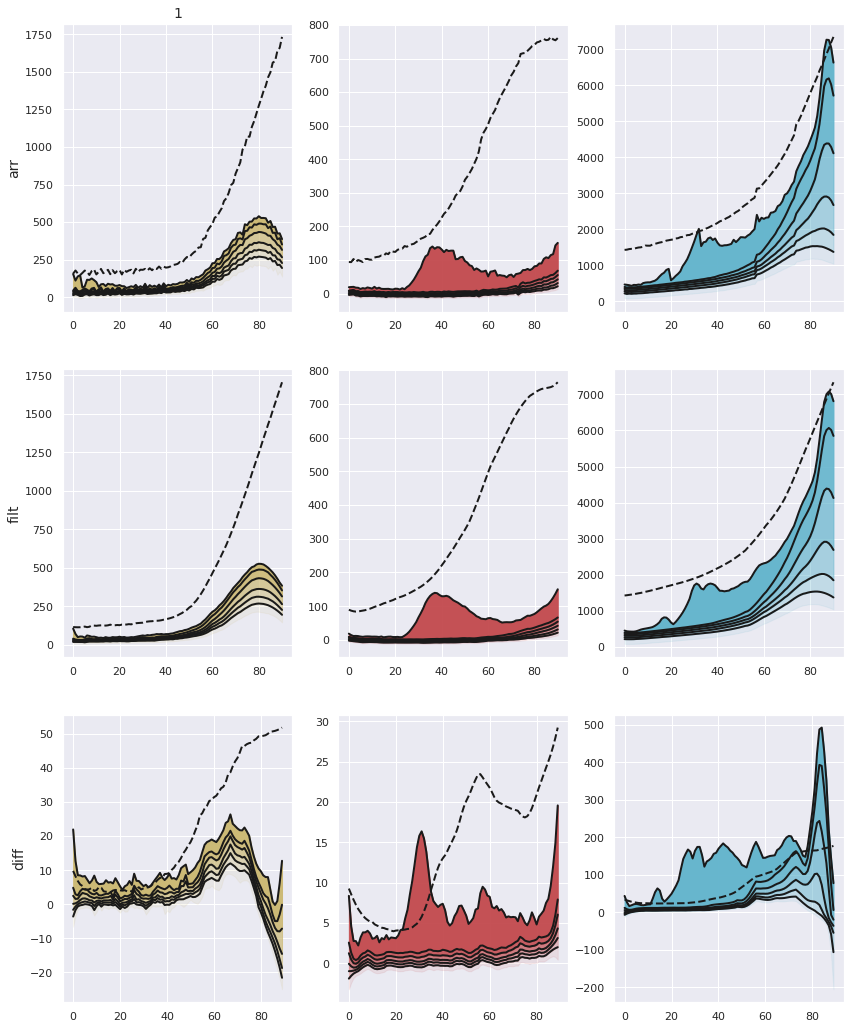

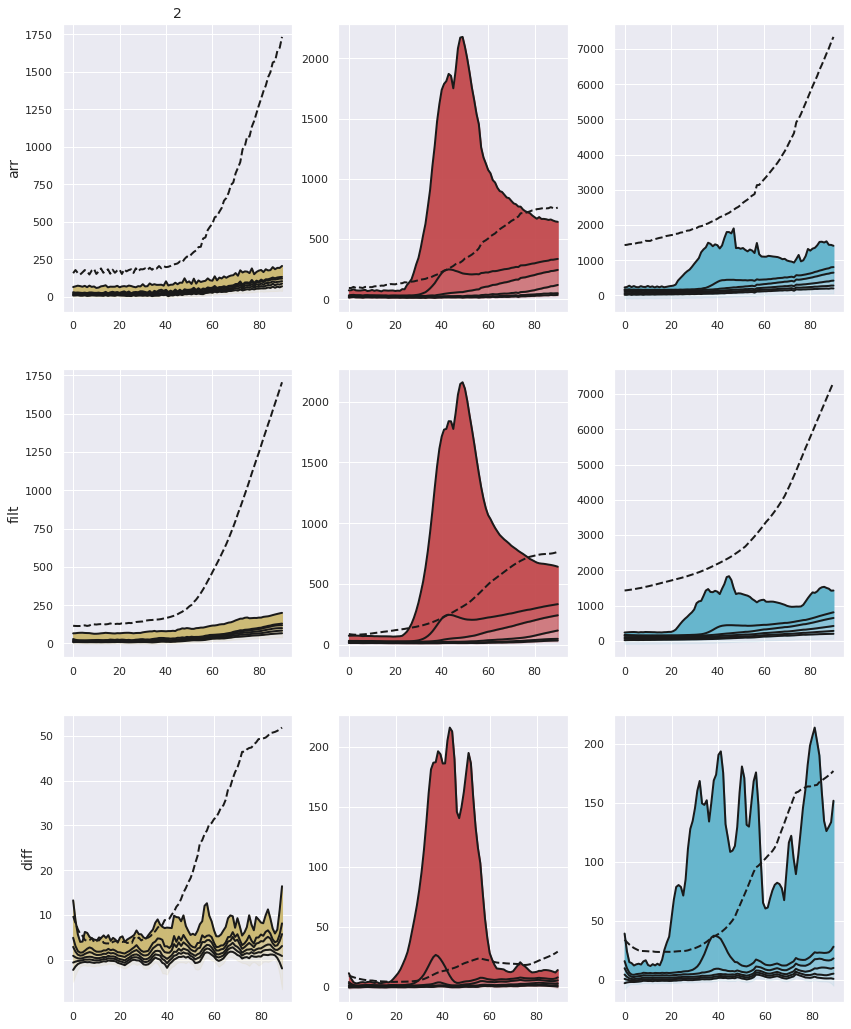

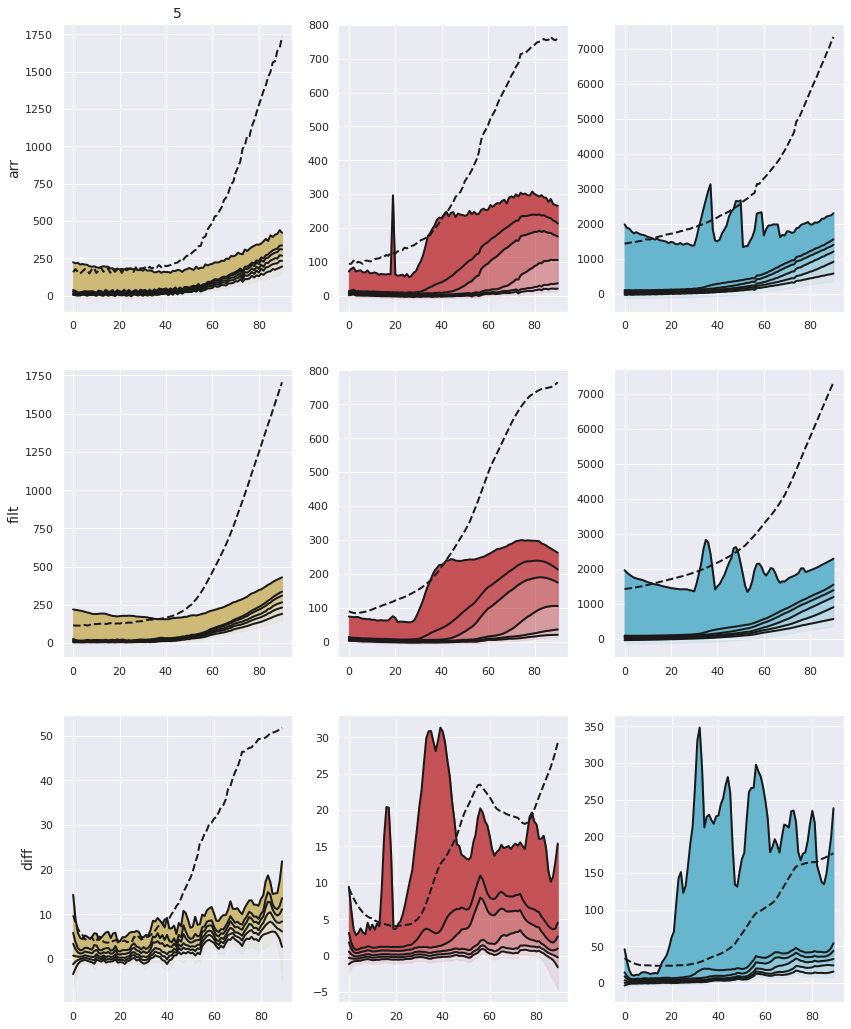

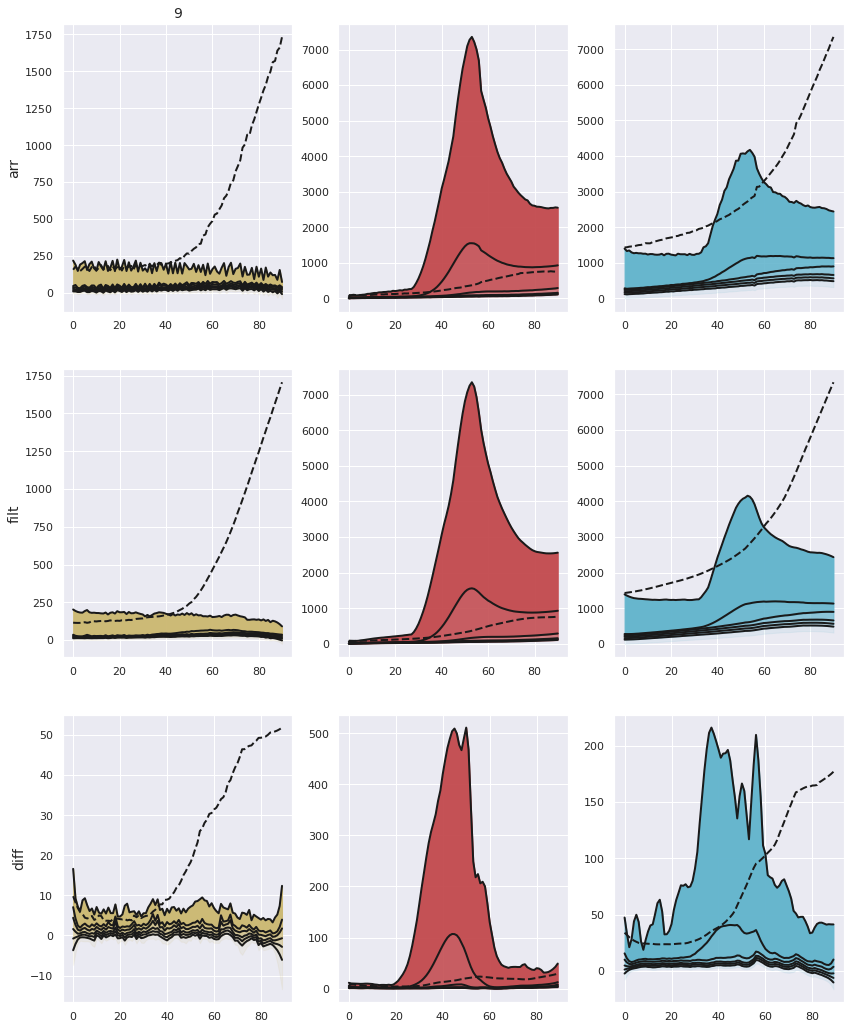

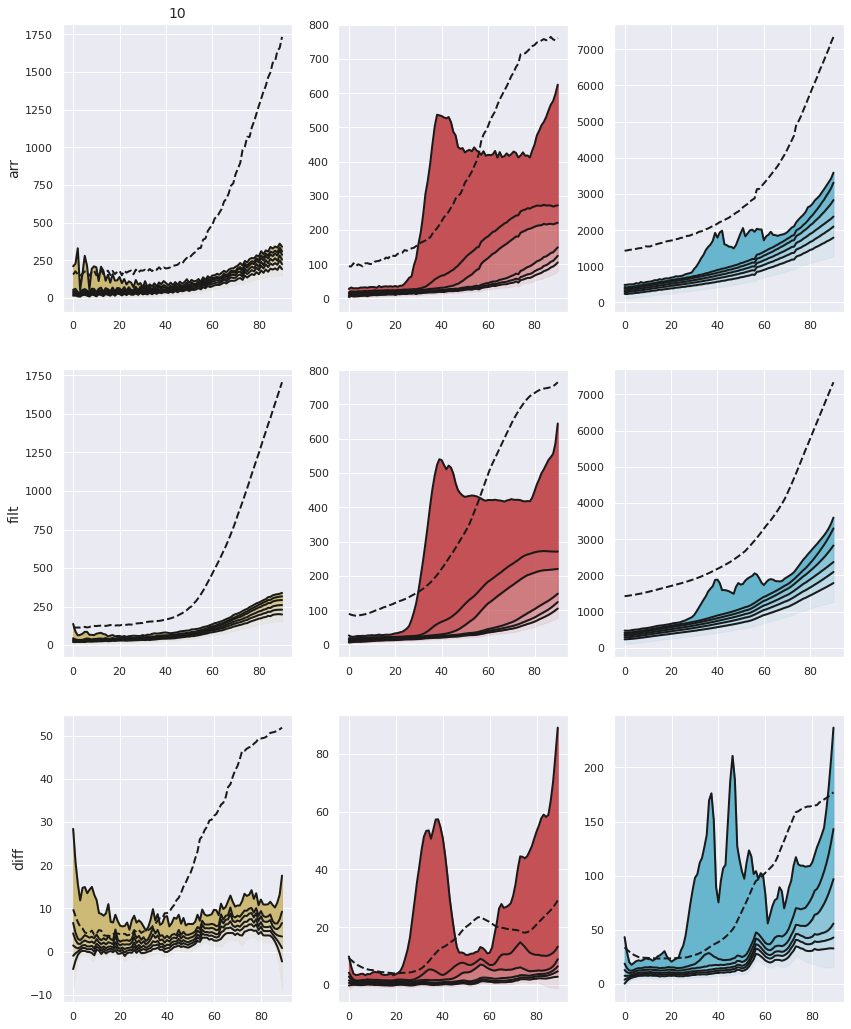

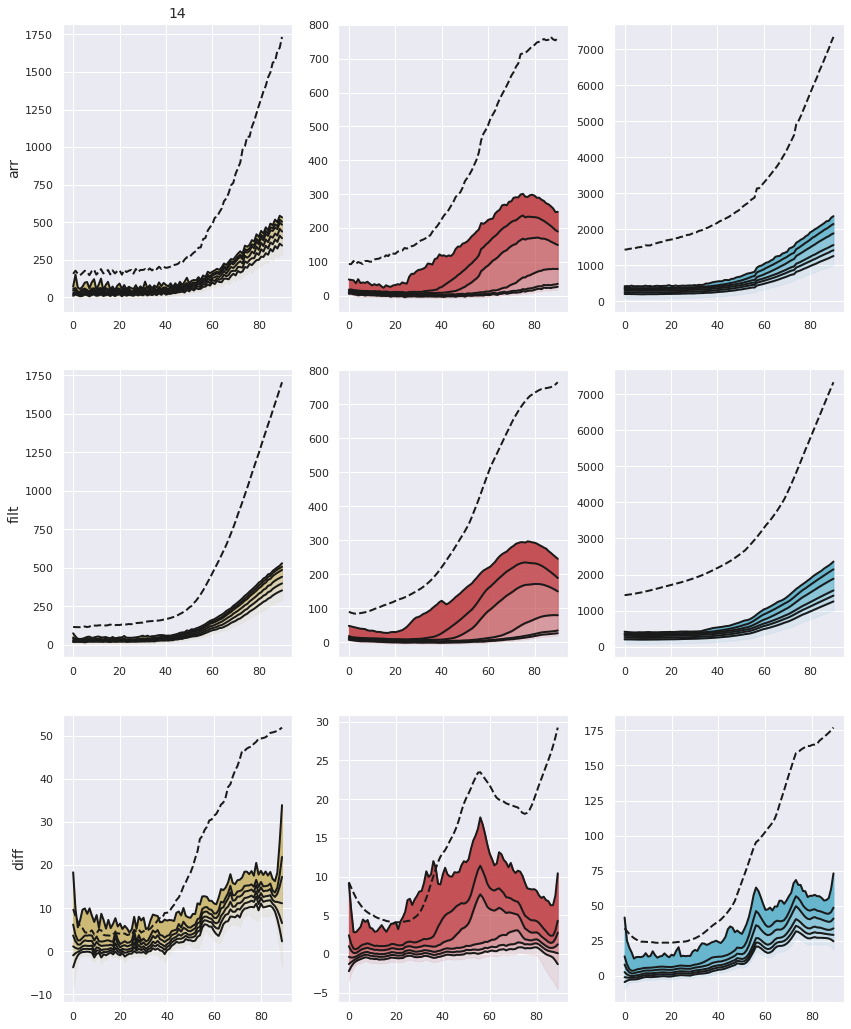

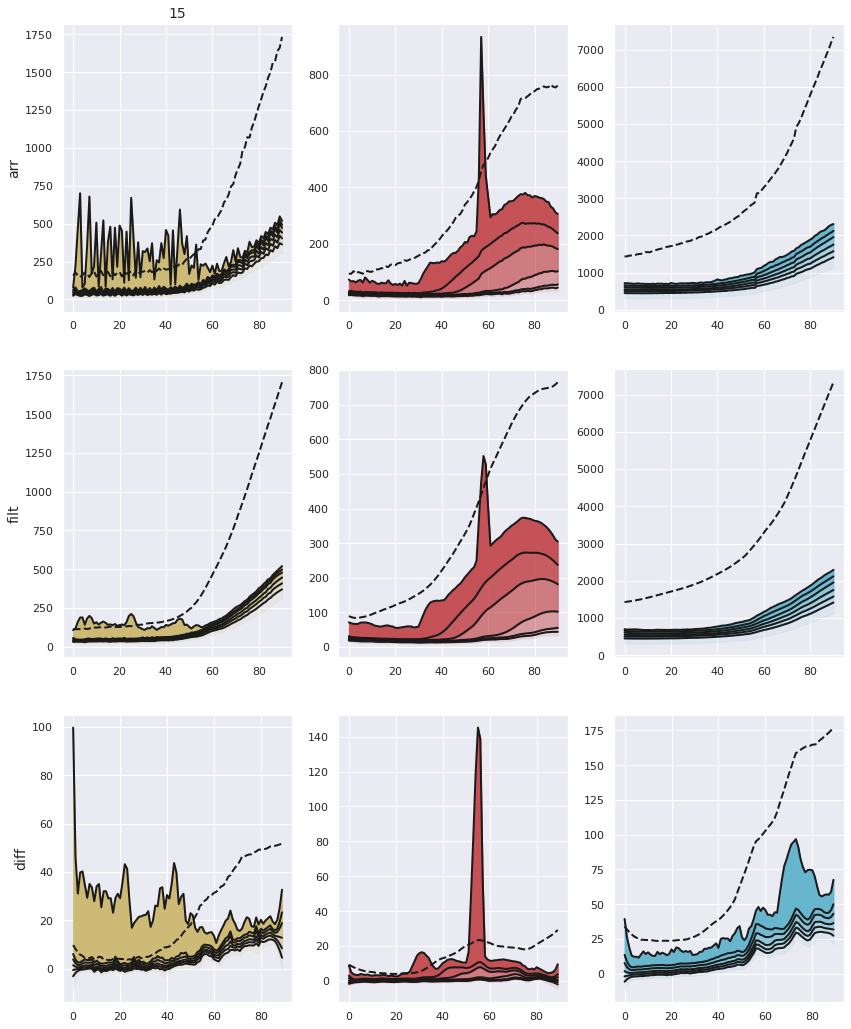

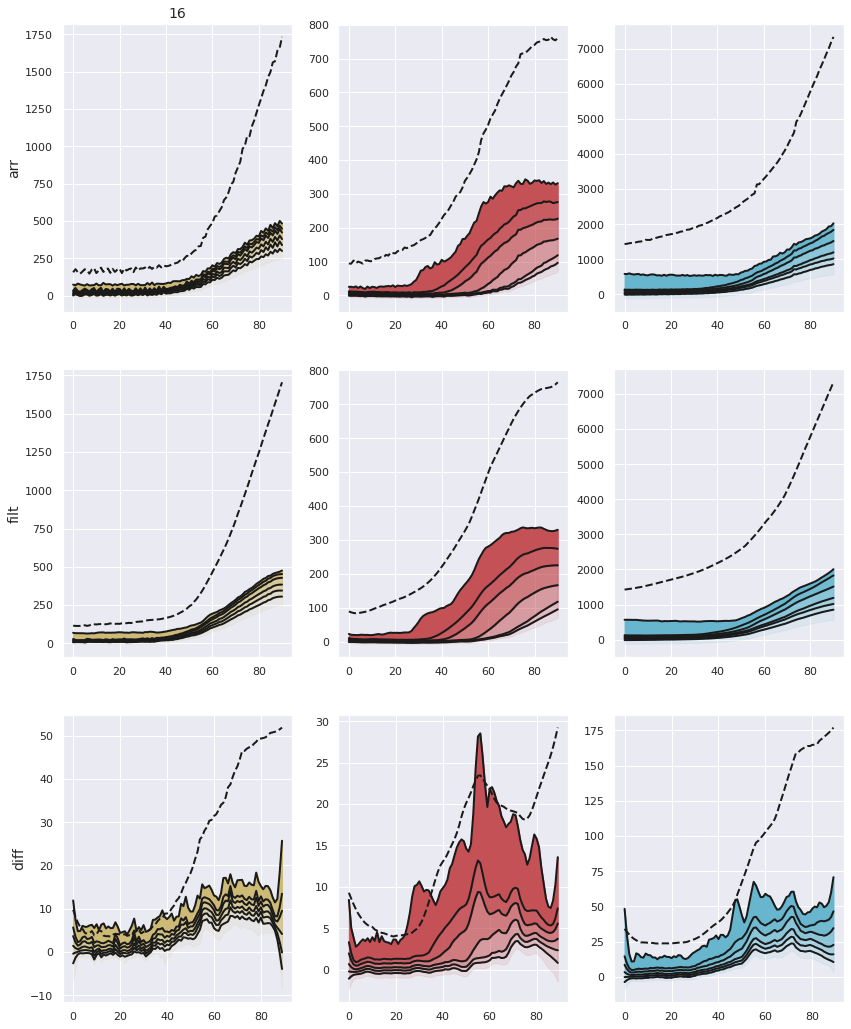

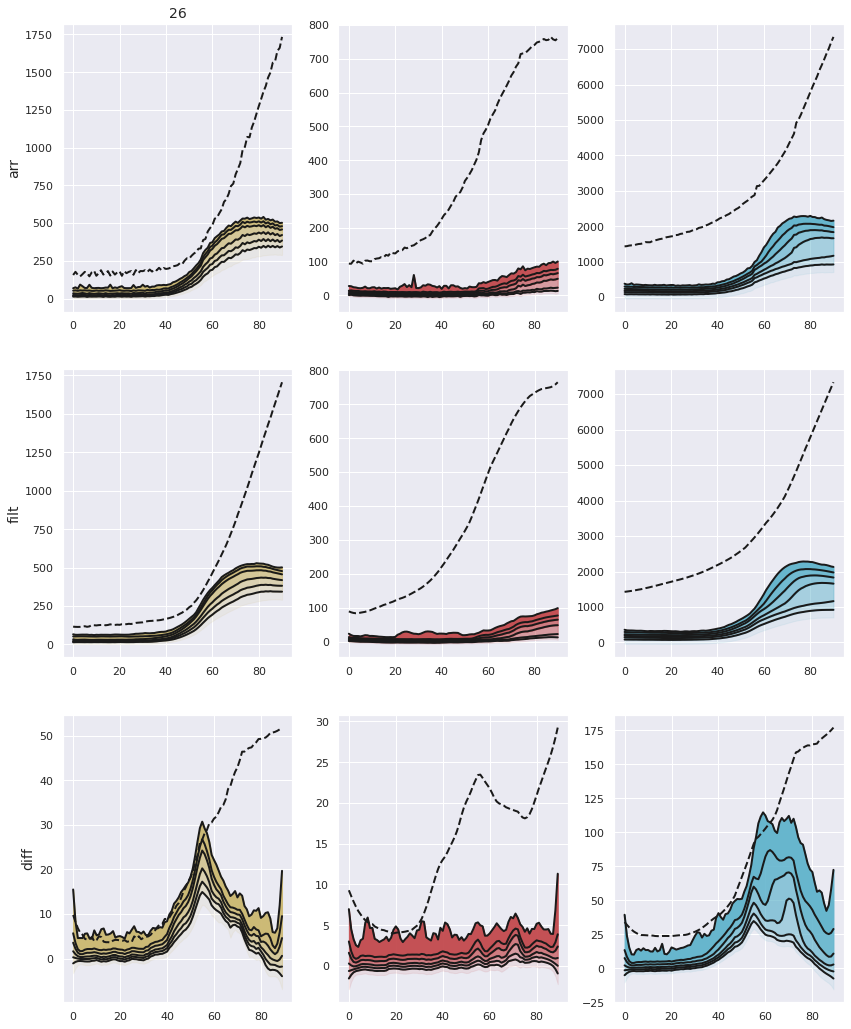

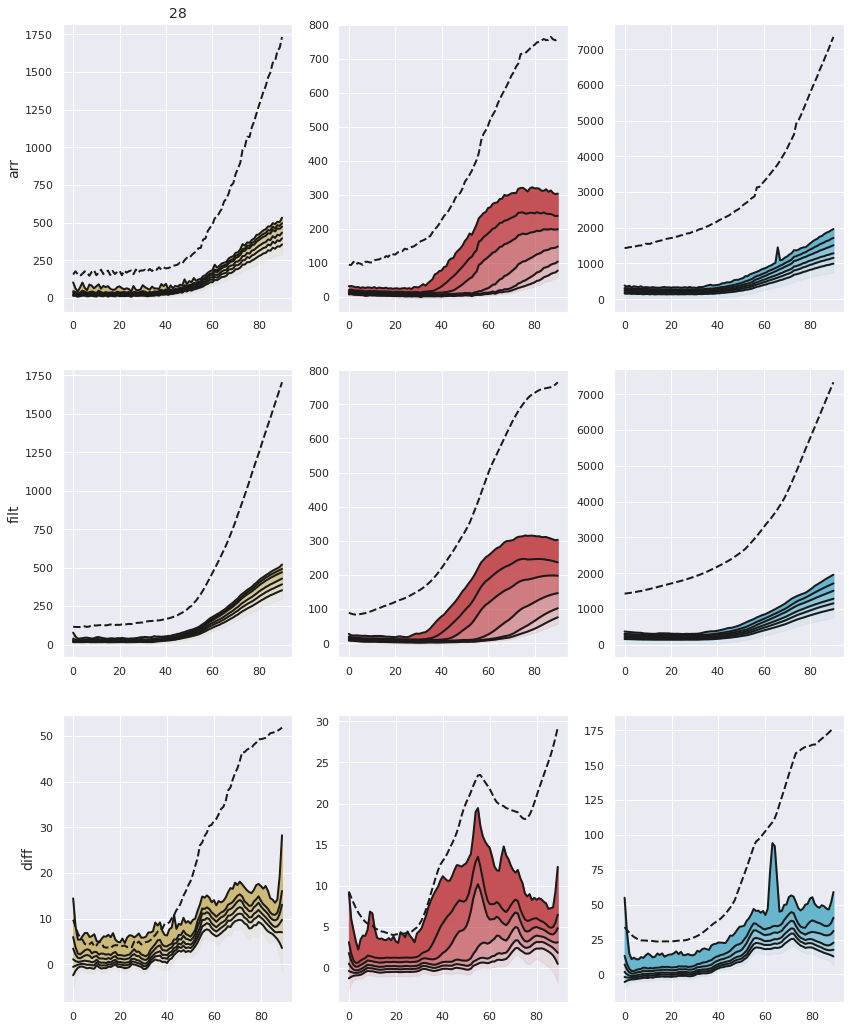

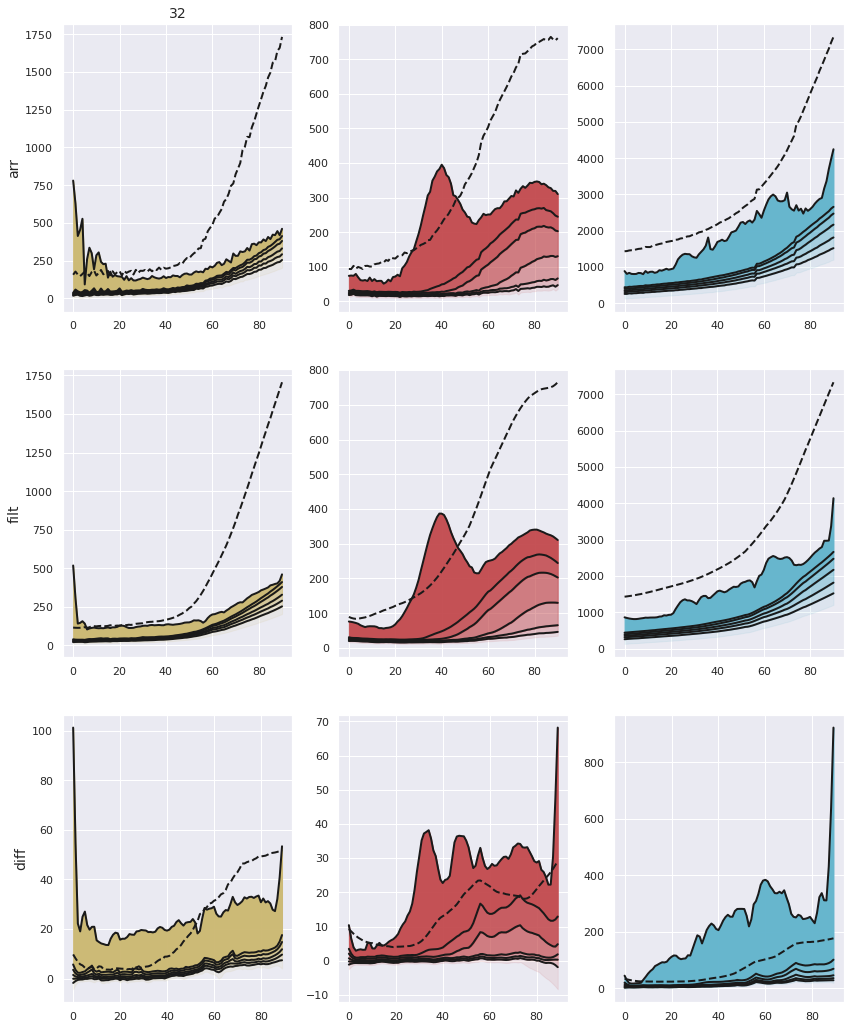

In [22]:

bounds = [0.1,0.3,0.5,0.7,0.9,0.98,1]
mpl_colors = np.array(mma.mpl_named_colors)[acq.chan_ind_list]
ylabs = ['arr', 'filt', 'diff']
for pad in [1,2,5,9,10,14,15,16,26,28,32]:
    im_arr = skimage.external.tifffile.imread(tiff_fn_tmpl.format(pad)).reshape((91,3,512,512))
    im_filt = signal.savgol_filter(im_arr, 9, 2, axis=0)
    im_diff = np.diff(im_filt, axis=0)
    im_diff = signal.savgol_filter(im_diff, 9, 2, axis=0)
    fig, axs = plt.subplots(3,3,figsize=(14,18))
    for i_im, arr in enumerate([im_arr, im_filt, im_diff]):
#         thresh_vecs = thresh_vecs_list[i_im]
        f_vec = np.arange(arr.shape[0])
        bound_arrs = np.quantile(arr, q=bounds, axis=(2,3))
        for color, ci in zip(mpl_colors, [0,1,2]):
#             thresh_vec = thresh_vecs[ci]
            m_inds = (ylabs[i_im], ci, slice(None))
            thresh_vec = thresh_df.loc[m_inds,'threshold']
            bound_vecs = bound_arrs[:,:,ci]
            ax = axs[i_im, ci]
            for b_i, bound_lims in enumerate(zip(bound_vecs[:-1,:],bound_vecs[1:,:])):
                l_bound = bound_lims[0]
                h_bound = bound_lims[1]
                _ = ax.plot(f_vec, h_bound, c='k')
                b_val = bounds[b_i]
                _ = ax.fill_between(f_vec, l_bound, h_bound, color=color, alpha=b_val)
            _ = ax.plot(f_vec, thresh_vec, '--k')
        axs[i_im,0].set_ylabel(ylabs[i_im])
    axs[0,0].set_title(pad)


#### High fluorescence pads

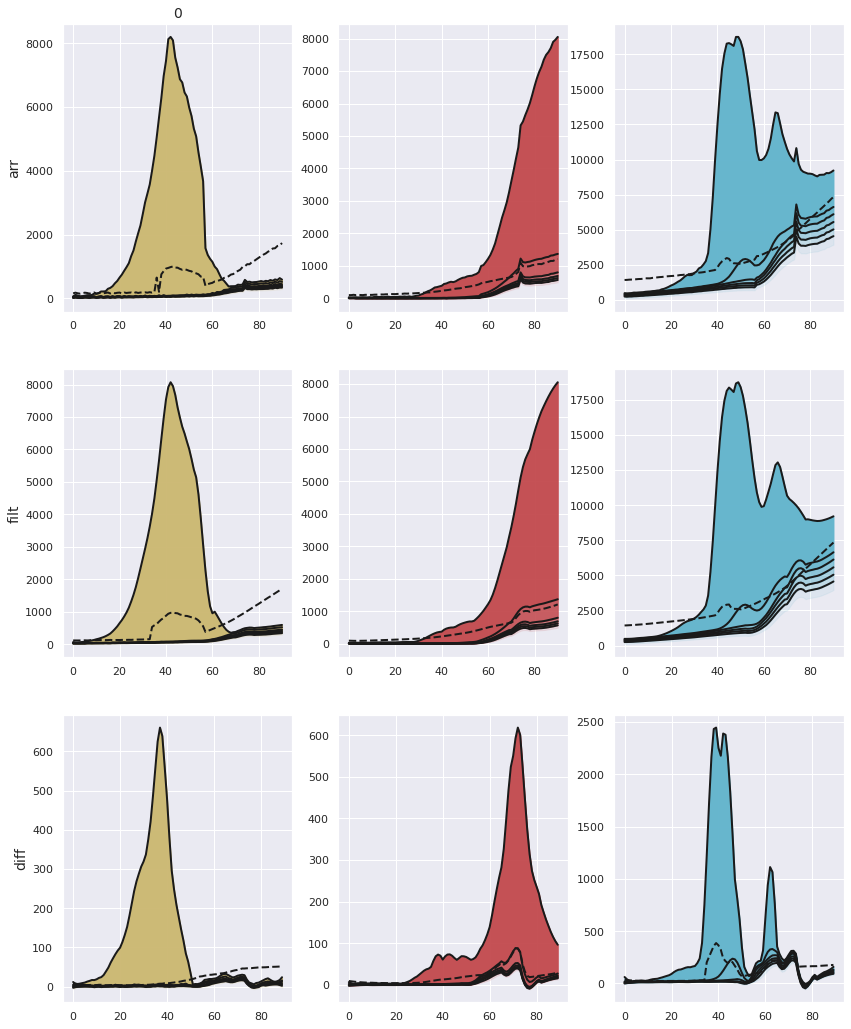

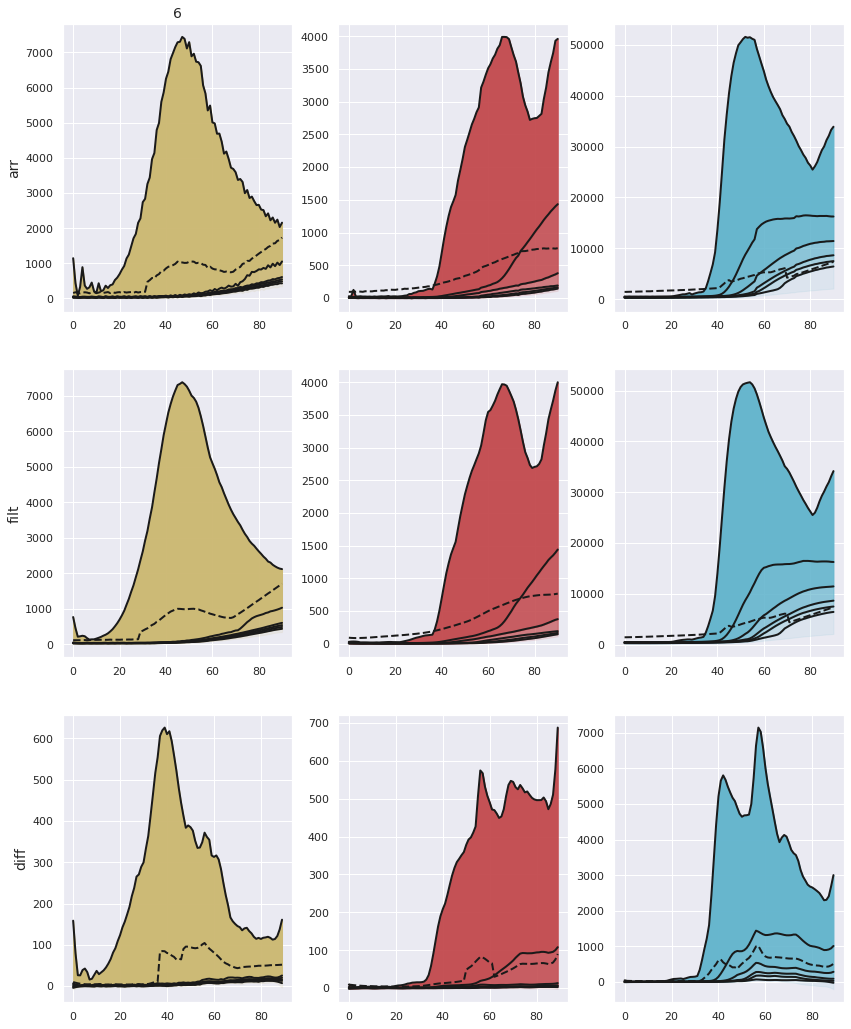

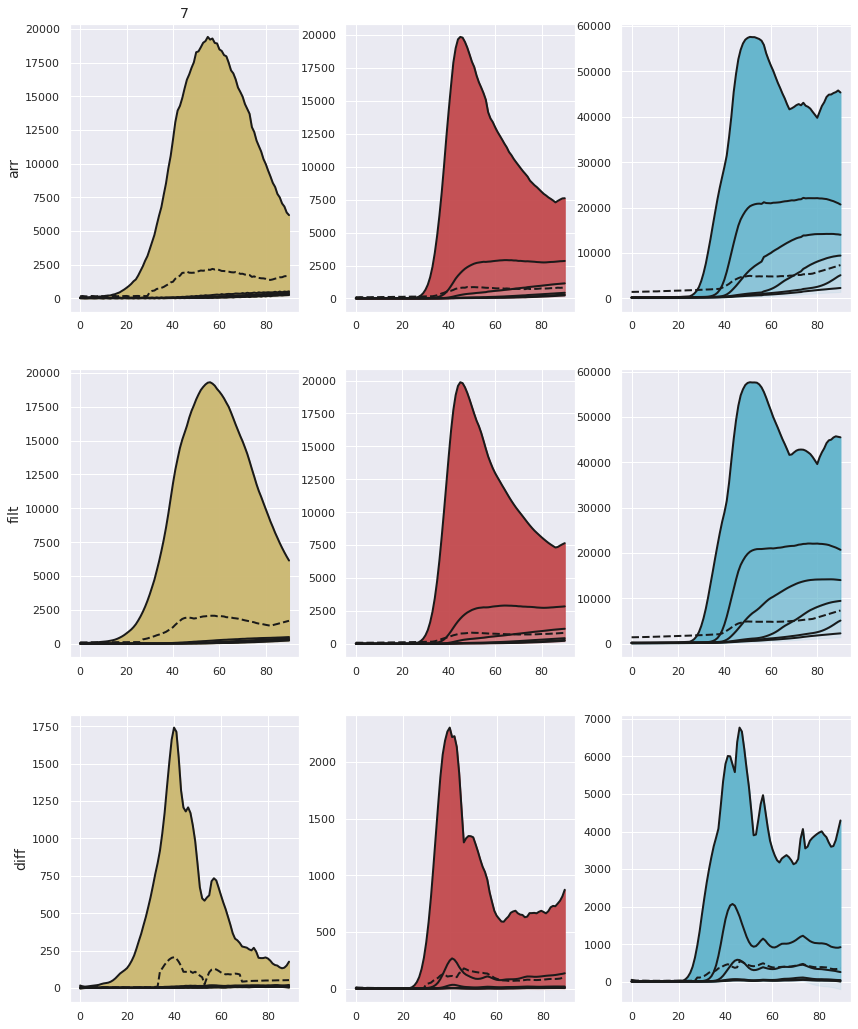

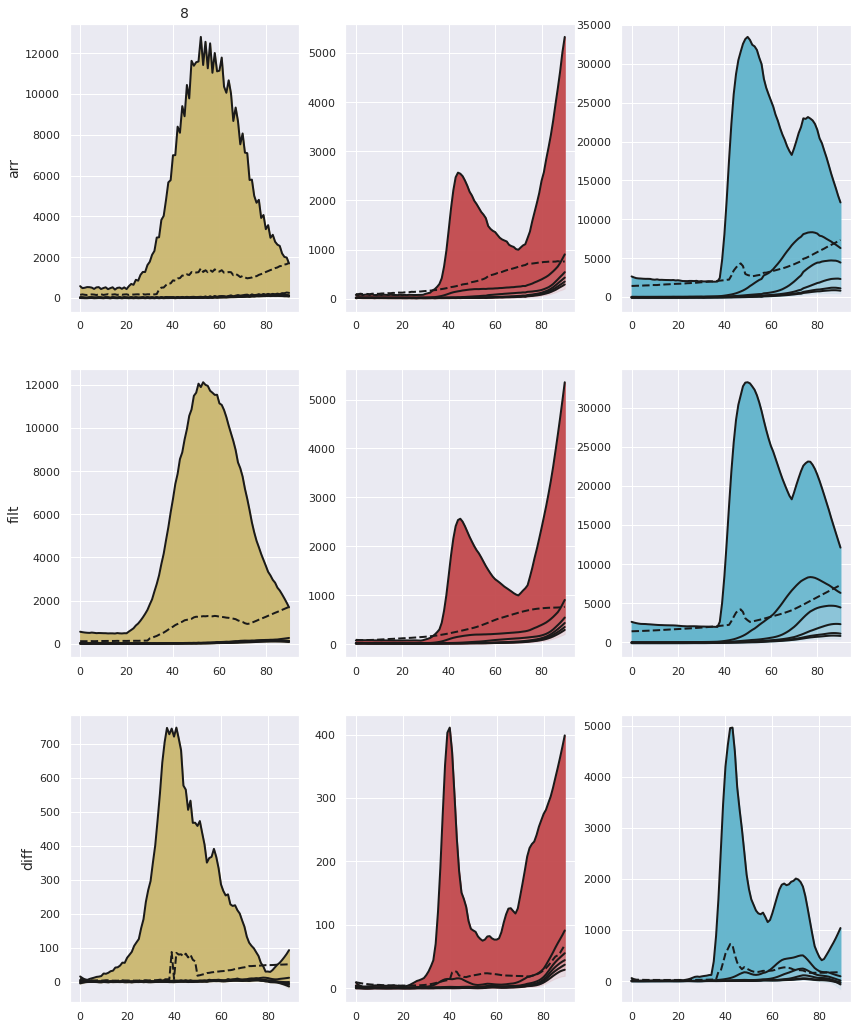

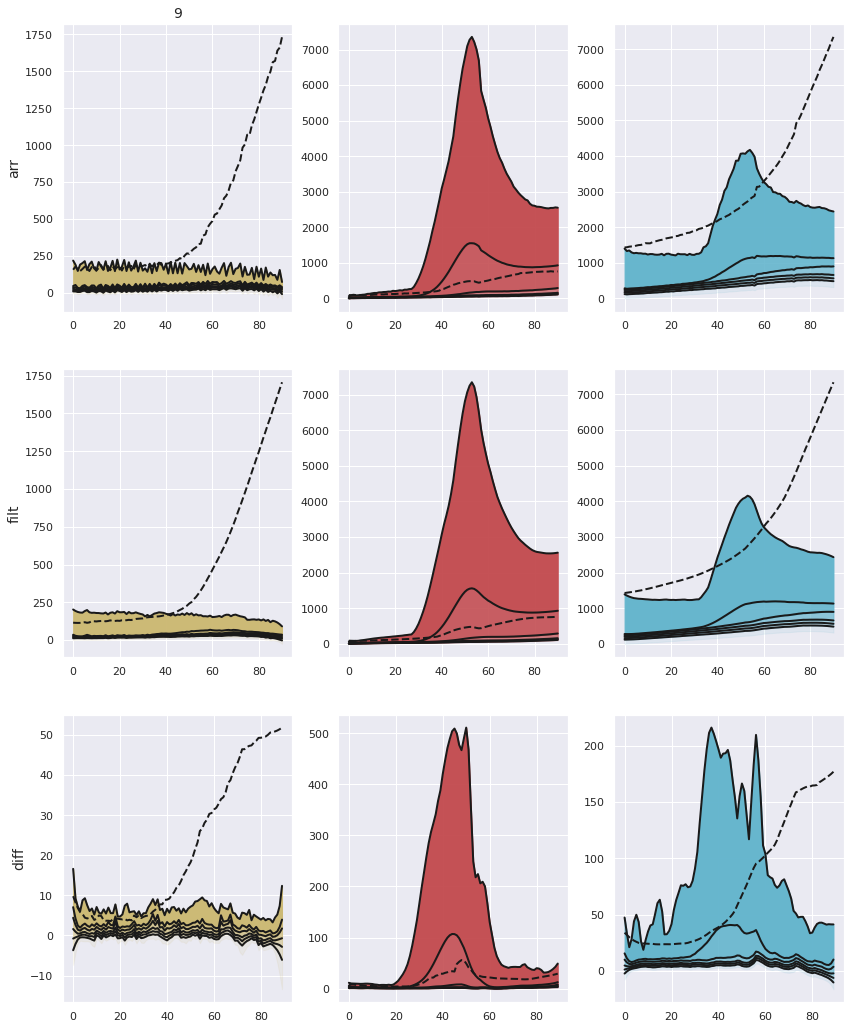

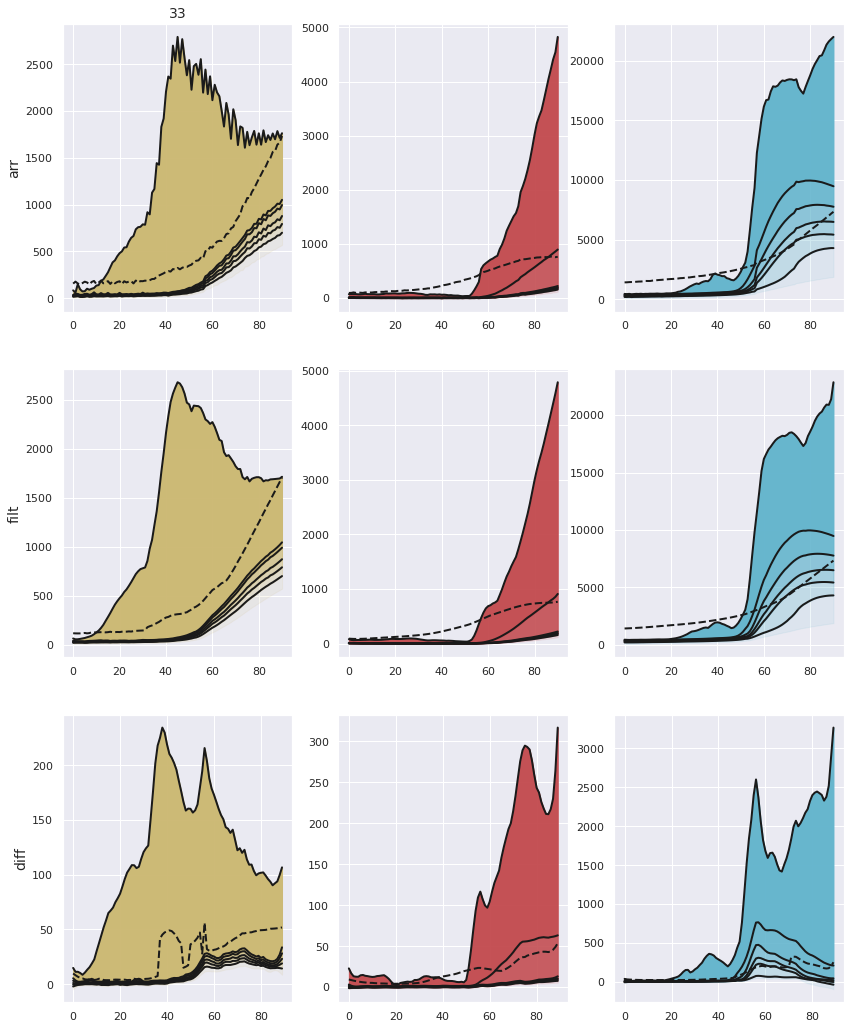

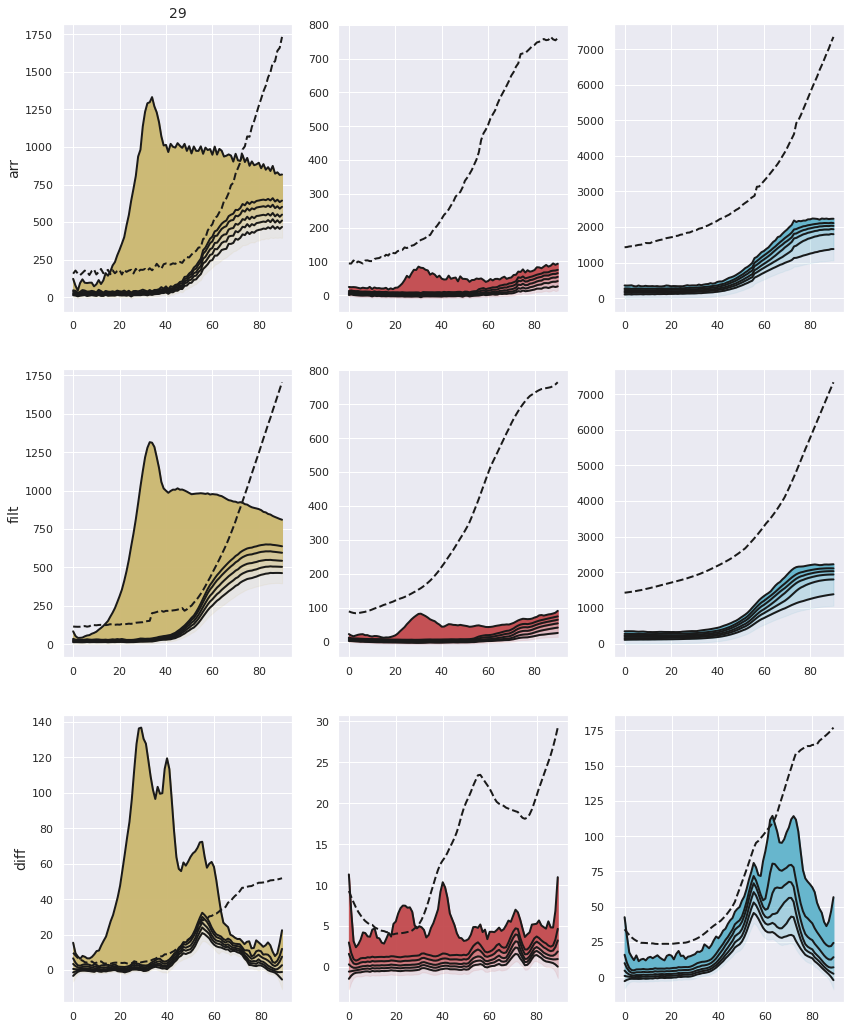

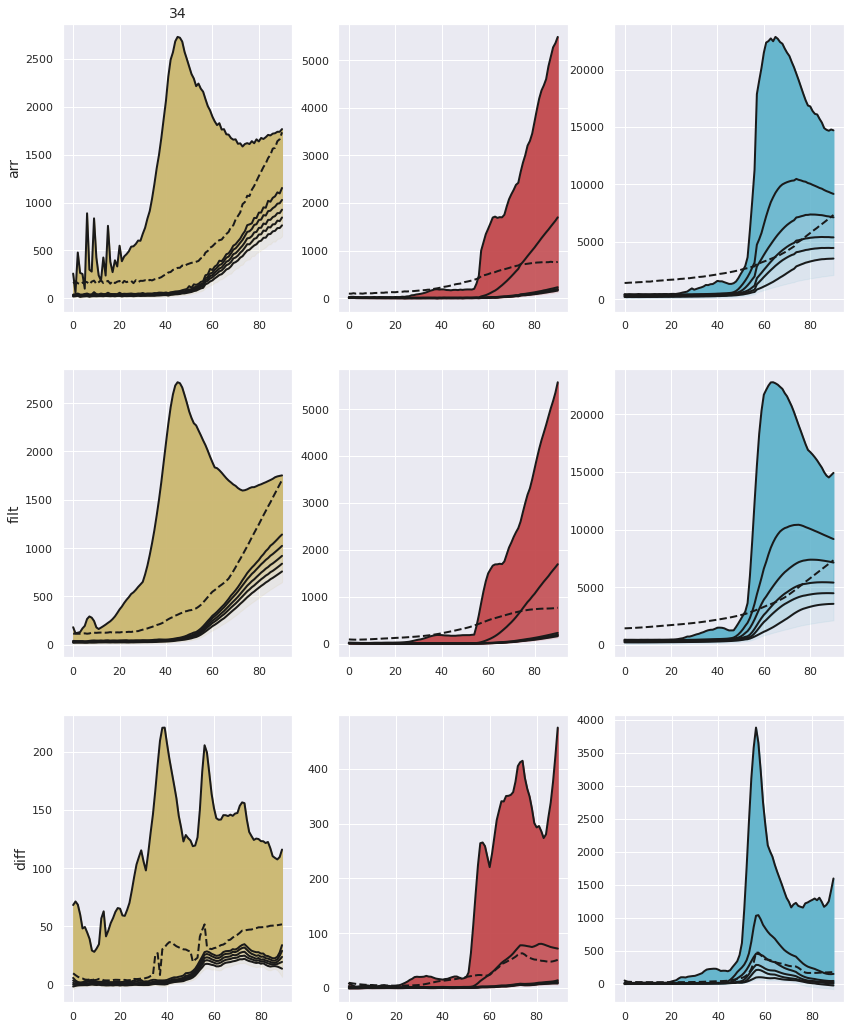

In [23]:
def thresh_helper(arr):
    initial_guess = np.quantile(arr, 0.97)
    thresh = skimage.filters.threshold_li(arr, tolerance=5, initial_guess=initial_guess)
    return thresh
bounds = [0.1,0.3,0.5,0.7,0.9,0.98,1]
mpl_colors = np.array(mma.mpl_named_colors)[acq.chan_ind_list]
ylabs = ['arr', 'filt', 'diff']
for pad in [0,6,7,8,9,33,29,34]:
    im_arr = skimage.external.tifffile.imread(tiff_fn_tmpl.format(pad)).reshape((91,3,512,512))
    im_filt = signal.savgol_filter(im_arr, 9, 2, axis=0)
    im_diff = np.diff(im_filt, axis=0)
    im_diff = signal.savgol_filter(im_diff, 9, 2, axis=0)
    fig, axs = plt.subplots(3,3,figsize=(14,18))
    for i_im, arr in enumerate([im_arr, im_filt, im_diff]):
#         thresh_vecs = thresh_vecs_list[i_im]
        f_vec = np.arange(arr.shape[0])
        bound_arrs = np.quantile(arr, q=bounds, axis=(2,3))
        for color, ci in zip(mpl_colors, [0,1,2]):
#             thresh_vec = thresh_vecs[ci]
            m_inds = (ylabs[i_im], ci, slice(None))
            thresh_mins = thresh_df.loc[m_inds,'threshold']
            thresh_vec = [np.max((thresh_helper(arr[f,ci,:,:]),thresh_mins[f])) for f in f_vec]
            bound_vecs = bound_arrs[:,:,ci]
            ax = axs[i_im, ci]
            for b_i, bound_lims in enumerate(zip(bound_vecs[:-1,:],bound_vecs[1:,:])):
                l_bound = bound_lims[0]
                h_bound = bound_lims[1]
                _ = ax.plot(f_vec, h_bound, c='k')
                b_val = bounds[b_i]
                _ = ax.fill_between(f_vec, l_bound, h_bound, color=color, alpha=b_val)
            _ = ax.plot(f_vec, thresh_vec, '--k')
        axs[i_im,0].set_ylabel(ylabs[i_im])
    axs[0,0].set_title(pad)


#### algorithmic thresholding on high pads for comparison

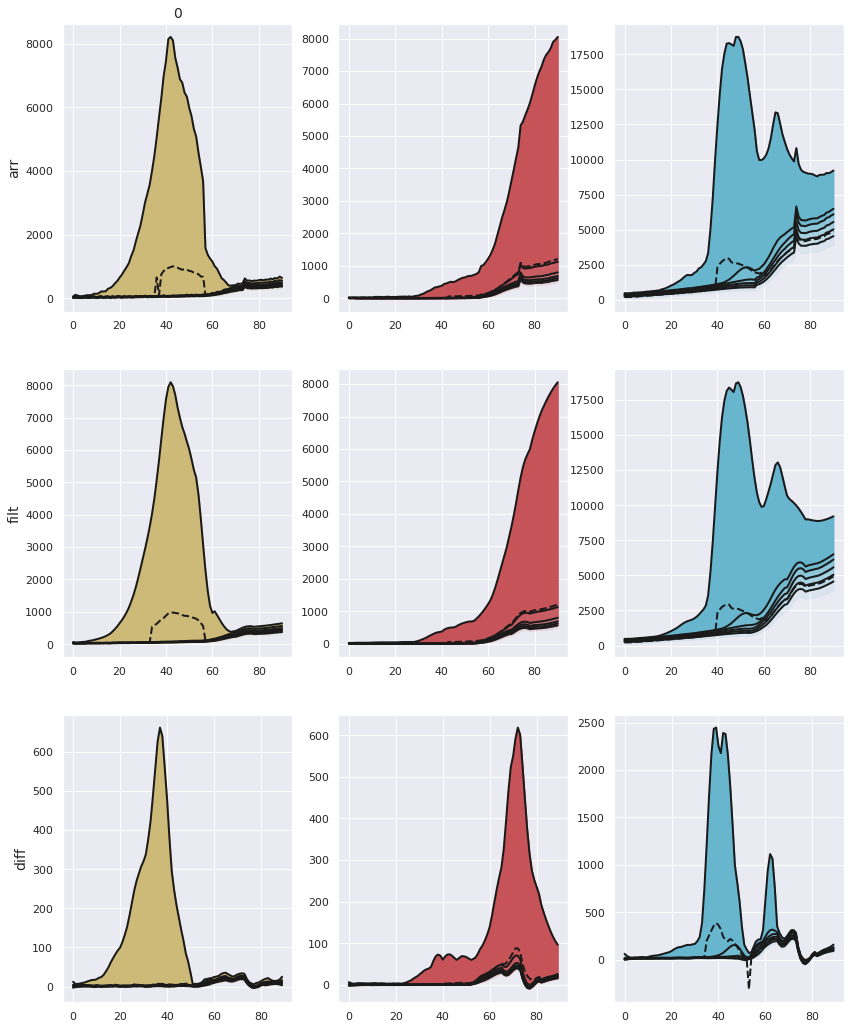

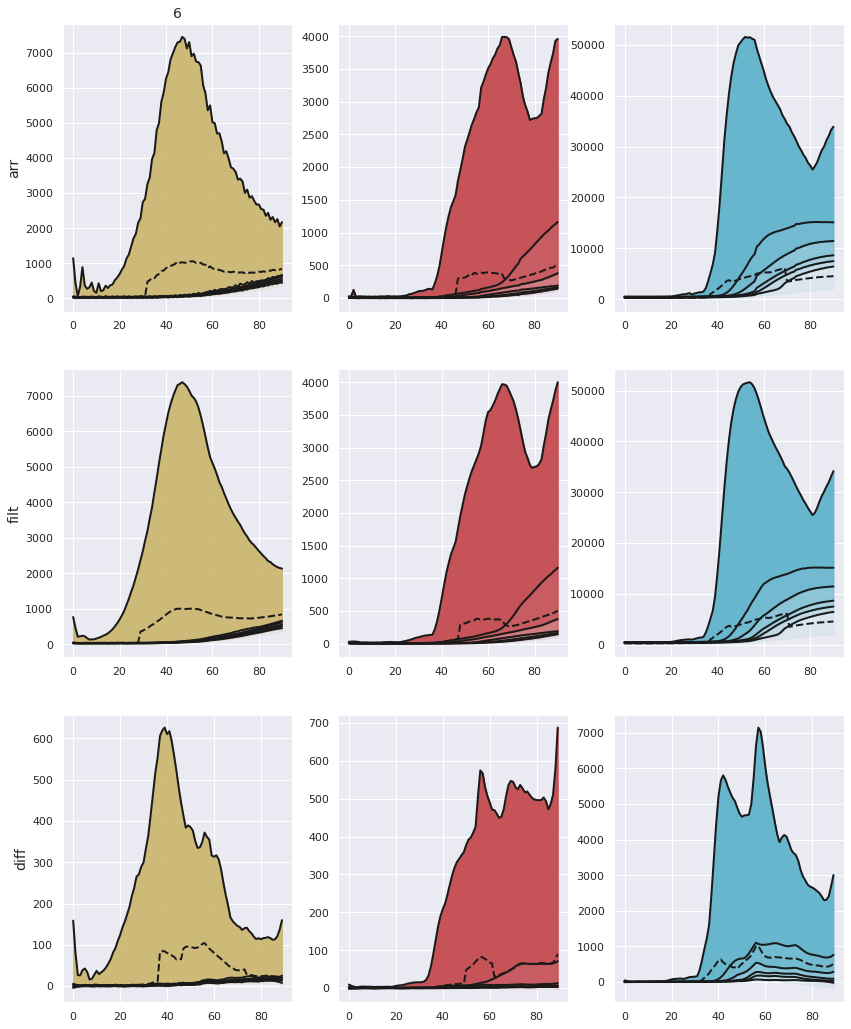

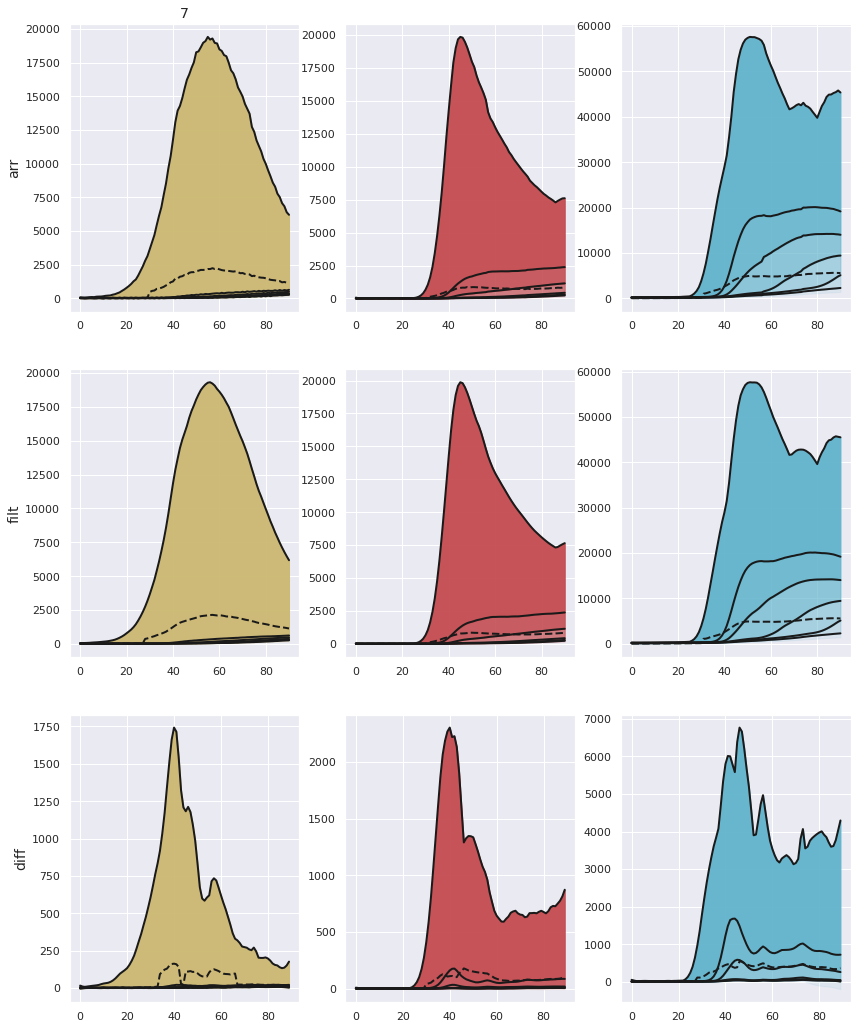

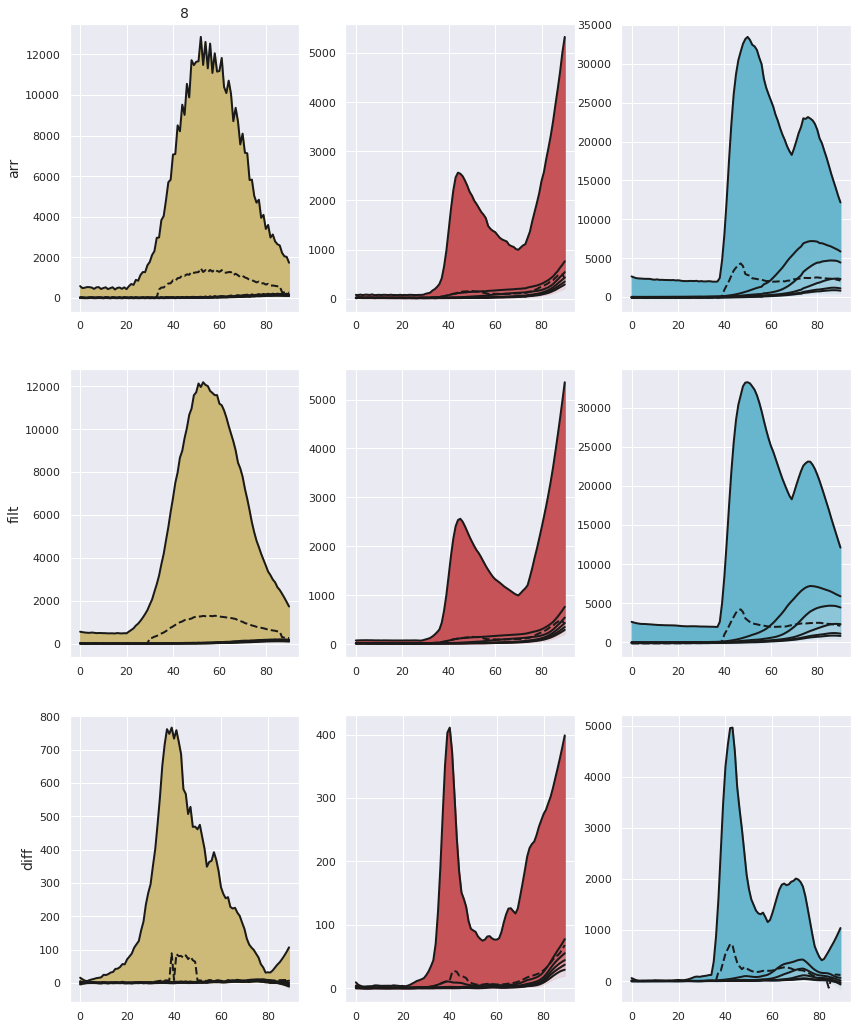

In [190]:
def thresh_helper(arr):
    initial_guess = np.quantile(arr, 0.97)
    thresh = skimage.filters.threshold_li(arr, tolerance=5, initial_guess=initial_guess)
    return thresh
bounds = [0.1,0.3,0.5,0.7,0.9,0.97,1]
mpl_colors = np.array(mma.mpl_named_colors)[acq.chan_ind_list]
ylabs = ['arr', 'filt', 'diff']
for pad in [0,6,7,8]:
    im_arr = skimage.external.tifffile.imread(tiff_fn_tmpl.format(pad)).reshape((91,3,512,512))
    im_filt = signal.savgol_filter(im_arr, 9, 2, axis=0)
    im_diff = np.diff(im_filt, axis=0)
    im_diff = signal.savgol_filter(im_diff, 9, 2, axis=0)
    fig, axs = plt.subplots(3,3,figsize=(14,18))
    for i_im, arr in enumerate([im_arr, im_filt, im_diff]):
        thresh_vecs = thresh_vecs_list[i_im]
        f_vec = np.arange(arr.shape[0])
        bound_arrs = np.quantile(arr, q=bounds, axis=(2,3))
        for color, ci in zip(mpl_colors, [0,1,2]):
#             thresh_vec = thresh_vecs[ci]
            thresh_vec = [thresh_helper(arr[f,ci,:,:]) for f in f_vec]
            bound_vecs = bound_arrs[:,:,ci]
            ax = axs[i_im, ci]
            for b_i, bound_lims in enumerate(zip(bound_vecs[:-1,:],bound_vecs[1:,:])):
                l_bound = bound_lims[0]
                h_bound = bound_lims[1]
                _ = ax.plot(f_vec, h_bound, c='k')
                b_val = bounds[b_i]
                _ = ax.fill_between(f_vec, l_bound, h_bound, color=color, alpha=b_val)
            _ = ax.plot(f_vec, thresh_vec, '--k')
        axs[i_im,0].set_ylabel(ylabs[i_im])
    axs[0,0].set_title(pad)


## Testing out derivative thresholding

In [37]:
fn = '/central/scratchio/jparkin/tiffstacks/200626_finalday/img_1/pad0.tiff'
tfile = skimage.external.tifffile.TiffFile(fn)
metadata_str = tfile.info()
split_list = metadata_str.split('\n')
imj_flag = False
imagej_lines = []
for line in split_list:
    if imj_flag:
        key, val = line.split(':')
        imagej_lines.append((key[2:],val[1:]))
    if '* ImageJ' in line:
        imj_flag = True
dict(imagej_lines)

{'bg_option': 'pos_list',
 'bg_sigma': '64',
 'channels': '273',
 'hyperstack': 'True',
 'images': '273',
 'mode': 'grayscale',
 'scale': '1',
 'sigma': '2'}

In [18]:
mma = importlib.reload(mma)

In [20]:
pad_ind = 9
procdiff = mma.ProcessUnorderedDiff(acq, pad_ind, scale=1, sigma=2, bg_sigma=64, 
                                    print_img=True, bg_option='pos_list',diff=True)
plt.close('all')

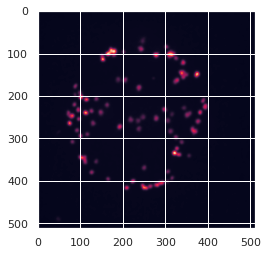

In [21]:
im = procdiff.arr[45,1,:,:]
plt.imshow(im)

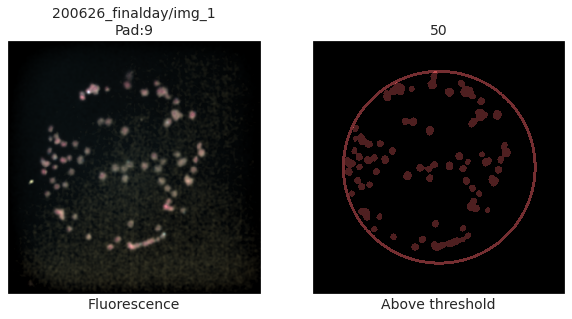

In [22]:
procdiff.printer._setup_figure()
procdiff.printer.animate(50)
# plt.

In [ ]:
procdiff.printer._setup_figure()
# anim = procdiff.printer.get_animation()
fig = procdiff.printer.fig
# func = procdiff.printer.animate
def func(frame, proc=procdiff):
    procdiff.process_frame(frame)
frames = acq.frame_vec
anim = mma.anm.FuncAnimation(fig, func, interval=70, frames=frames[:-1])
HTML(anim.to_html5_video())

### Correcting for rfp activation in yfp excitation

In [118]:
mma = importlib.reload(mma)
pad_ind = 20
procdiff = mma.ProcessUnorderedDiff(acq, pad_ind, scale=1, sigma=2, bg_sigma=64, 
                                    print_img=False, bg_option='pos_list',diff=True)

In [80]:
csv_fn = os.path.join(acq.super_dir,'csvs','pad{}.csv'.format(pad_ind))
pad_df = pd.read_csv(csv_fn)
thresh_dict = pad_df[['frame','channel','thresh']].groupby(['frame','channel']).agg(np.min)

In [75]:
np.ndarray?

In [92]:
nf, nc, nh, nw = procdiff.diff_arr.shape
areas = np.zeros(50)
# rfp_fluors = []
# yfp_fluors = []
# frames = []
data = []
for f_i in np.arange(60):
    yfp_arr = procdiff.arr[f_i,0,:,:]
    rfp_arr = procdiff.arr[f_i,1,:,:]
    cfp_arr = procdiff.arr[f_i,2,:,:]
    key = (np.float(f_i), 3.0)
    if key in thresh_dict.index:
        thresh = thresh_dict.loc[key,'thresh']
        bw_im = rfp_arr >= thresh
        if np.sum(bw_im)>4:
            masks = skimage.measure.label(bw_im)
            rprops = skimage.measure.regionprops(masks)
            for rp in rprops:
                area, label = rp.area, rp.label
                mask_im = masks == label
                rfp_fluors = rfp_arr[mask_im]
                yfp_fluors = yfp_arr[mask_im]
                frame_vec = np.ones(area)*f_i
                new_data = np.array([rfp_fluors, yfp_fluors, frame_vec]).T
                data.append(new_data)
    else:
        print('skipped',key)
data = np.concatenate(data,axis=0)

skipped (0.0, 3.0)
skipped (1.0, 3.0)
skipped (2.0, 3.0)
skipped (3.0, 3.0)
skipped (4.0, 3.0)
skipped (5.0, 3.0)
skipped (6.0, 3.0)
skipped (7.0, 3.0)
skipped (8.0, 3.0)
skipped (9.0, 3.0)
skipped (10.0, 3.0)
skipped (11.0, 3.0)
skipped (12.0, 3.0)
skipped (14.0, 3.0)


[ 0.05850016 55.03760116]


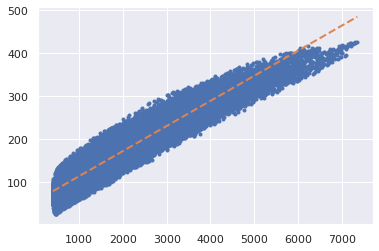

In [114]:
# Rfp to yfp-channel error
fluor_df = pd.DataFrame(data, columns=['rfp','yfp','frame'])
plot_df = fluor_df.loc[fluor_df.frame>45,:]
x, y = plot_df[['rfp','yfp']].values.T
pfit = np.polyfit(x,y,1)
a, b = pfit
print(pfit)
_ = plt.plot(plot_df.rfp, plot_df.yfp,'.')
x_sim = np.linspace(x.min(),x.max(),10)
y_sim = a*x_sim + b
_ = plt.plot(x_sim, y_sim, '--')


In [119]:
nf, nc, nh, nw = procdiff.diff_arr.shape
# areas = np.zeros(50)
# rfp_fluors = []
# yfp_fluors = []
# frames = []
data = []
for f_i in np.arange(60):
    yfp_arr = procdiff.arr[f_i,0,:,:]
    rfp_arr = procdiff.arr[f_i,1,:,:]
    cfp_arr = procdiff.arr[f_i,2,:,:]
    key = (np.float(f_i), 2.0)
    if key in thresh_dict.index:
        thresh = thresh_dict.loc[key,'thresh']
        bw_im = yfp_arr >= thresh
        if np.sum(bw_im)>4:
            masks = skimage.measure.label(bw_im)
            rprops = skimage.measure.regionprops(masks)
            for rp in rprops:
                area, label = rp.area, rp.label
                mask_im = masks == label
                rfp_fluors = rfp_arr[mask_im]
                yfp_fluors = yfp_arr[mask_im]
                cfp_fluors = cfp_arr[mask_im]
                frame_vec = np.ones(area)*f_i
                new_data = np.array([yfp_fluors, rfp_fluors, cfp_fluors, frame_vec]).T
                data.append(new_data)
    else:
        print('skipped',key)
data = np.concatenate(data,axis=0)
fluor_df = pd.DataFrame(data, columns=['yfp','rfp','cfp','frame'])

skipped (0.0, 2.0)
skipped (1.0, 2.0)
skipped (2.0, 2.0)
skipped (3.0, 2.0)
skipped (4.0, 2.0)
skipped (5.0, 2.0)
skipped (6.0, 2.0)
skipped (7.0, 2.0)
skipped (8.0, 2.0)
skipped (9.0, 2.0)
skipped (10.0, 2.0)
skipped (11.0, 2.0)
skipped (12.0, 2.0)
skipped (13.0, 2.0)
skipped (14.0, 2.0)
skipped (15.0, 2.0)
skipped (16.0, 2.0)
skipped (17.0, 2.0)
skipped (18.0, 2.0)
skipped (19.0, 2.0)
skipped (20.0, 2.0)
skipped (21.0, 2.0)
skipped (22.0, 2.0)
skipped (23.0, 2.0)
skipped (24.0, 2.0)
skipped (25.0, 2.0)
skipped (26.0, 2.0)
skipped (27.0, 2.0)
skipped (28.0, 2.0)
skipped (29.0, 2.0)
skipped (30.0, 2.0)
skipped (31.0, 2.0)
skipped (32.0, 2.0)
skipped (33.0, 2.0)
skipped (34.0, 2.0)
skipped (35.0, 2.0)
skipped (36.0, 2.0)
skipped (37.0, 2.0)
skipped (38.0, 2.0)
skipped (39.0, 2.0)
skipped (40.0, 2.0)
skipped (41.0, 2.0)
skipped (56.0, 2.0)
skipped (57.0, 2.0)
skipped (58.0, 2.0)
skipped (59.0, 2.0)


[3.38237142e-02 3.78937734e+02]


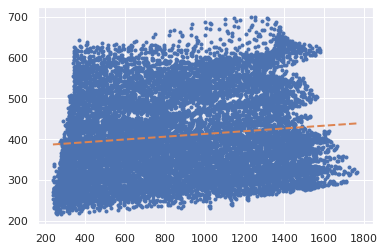

In [121]:
# Rfp to yfp-channel error
plot_df = fluor_df.loc[fluor_df.frame>45,:]
x, y = plot_df[['yfp','cfp']].values.T
pfit = np.polyfit(x,y,1)
a, b = pfit
print(pfit)
_ = plt.plot(x, y,'.')
x_sim = np.linspace(x.min(),x.max(),10)
y_sim = a*x_sim + b
_ = plt.plot(x_sim, y_sim, '--')


### Determining growth rate phases by yfp colonies

In [29]:
mma = importlib.reload(mma)
pad_ind = 6

In [8]:
procdiff = mma.ProcessUnorderedDiff(acq, pad_ind, scale=1, sigma=2, bg_sigma=64, 
                                    print_img=True, bg_option='pos_list',diff=True)
plt.close('all')

In [30]:
fitter = mma.FrontFitter(acq, diff=True)
pad_df = fitter.pad_peaks(pad_ind)

In [10]:
csv_fn = os.path.join(acq.super_dir,'csvs','diff_pad{}.csv'.format(pad_ind))
pad_df = pd.read_csv(csv_fn)
thresh_dict = pad_df[['frame','channel','thresh']].groupby(['frame','channel']).agg(np.min)


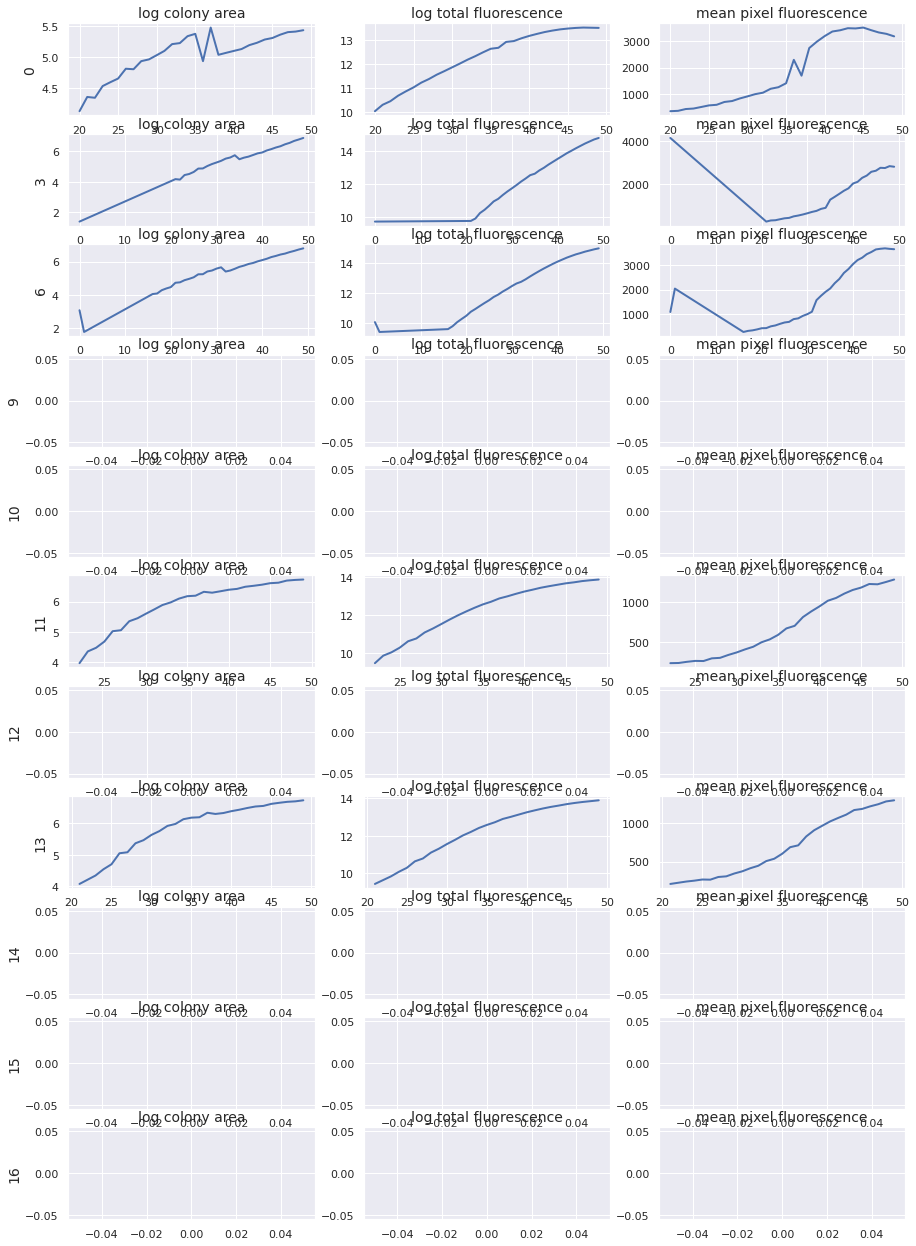

In [396]:
sub_metadf = metadata_df.groupby(['inducers','sender','deadcini']).get_group(('ir','jao',False))
n_pads = sub_metadf.shape[0]
fig, axs = plt.subplots(n_pads,3,figsize=(15,n_pads*2))
for plot_row, pad_ind in enumerate(sub_metadf.index.values):
    procdiff = mma.ProcessUnorderedDiff(acq, pad_ind, scale=1, sigma=2, bg_sigma=64, 
                                    print_img=False, bg_option='pos_list',diff=True)
    nf, nc, nh, nw = procdiff.diff_arr.shape
    areas = np.zeros(50)
    fluors = np.zeros(50)
    csv_fn = os.path.join(acq.super_dir,'csvs','pad{}.csv'.format(pad_ind))
    pad_df = pd.read_csv(csv_fn)
    thresh_dict = pad_df[['frame','channel','thresh']].groupby(['frame','channel']).agg(np.min)
    for f_i in np.arange(50):
        yfp_arr = procdiff.filt_arr[f_i,0,:,:]
        key = (f_i, 2)
        if key in thresh_dict.index:
            thresh = thresh_dict.loc[(f_i,2),'thresh']
            bw_im = yfp_arr > thresh
            if np.sum(bw_im)>40:
                masks = skimage.measure.label(bw_im)
                rp = skimage.measure.regionprops(masks, yfp_arr)[0]
                areas[f_i] = rp.area
                fluors[f_i] = np.sum(yfp_arr[yfp_arr>thresh])
    a_vec = areas[areas>1]
    fl_vec = fluors[areas>1]
    f_vec = np.arange(50)[areas>1]
    axs[plot_row, 0].plot(f_vec,np.log(a_vec))
    axs[plot_row, 0].set_title('log colony area')
    axs[plot_row, 0].set_ylabel(pad_ind)
    axs[plot_row, 1].plot(f_vec,np.log(fl_vec))
    axs[plot_row, 1].set_title('log total fluorescence')
    axs[plot_row, 2].plot(f_vec,fl_vec/a_vec)
    axs[plot_row, 2].set_title('mean pixel fluorescence')



/home/jparkin/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[3.97225150e-04 4.61631278e+00]')

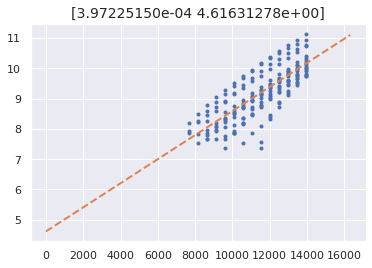

In [25]:
bvec = f_all_list < 30
f_sub, fl_sub = f_all_list[bvec]*8*60,np.log(fl_all_list)[bvec]
pfit = np.polyfit(f_sub, fl_sub, 1)
pfn = np.poly1d(pfit)
plt.plot(f_sub, fl_sub,'.')
f_sim = np.arange(35)*8*60
plt.plot(f_sim, pfn(f_sim),'--')
plt.title(pfit)

### Testing out new threshold crossing components
* distance as it is is the value r - ri. you'll need to measure ri somehow. 
* measure ri by taking sqrt of the area i suppose

In [23]:
mma = importlib.reload(mma)

In [41]:
pad_ind = 7
# tiff_dir = os.path.join('/central','scratchio','jparkin','tiffstacks',acq.expname,acq.acqname)
# tiff_fn = os.path.join(tiff_dir, 'pad{}.tiff'.format(pad_ind))
padhelper = mma.WriteHelper(acq, scale=1, pad_ind=pad_ind, bg_option='pos_list',sigma=2,bg_sigma=64)
# padhelper._check_tiff_metadata(padhelper.tiff_fn)
# arr = padhelper.load_tiffstack(padhelper.tiff_fn)

In [24]:
pad_ind = 7
procdiff = mma.ProcessUnorderedDiff(acq, pad_ind, scale=1, sigma=2, bg_sigma=64, 
                                    print_img=True, bg_option='pos_list',diff=True)
plt.close('all')

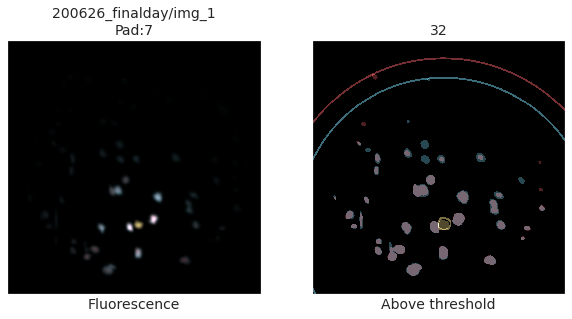

In [26]:
procdiff.diff = True
procdiff._setup_printer()
_ = procdiff.process_frame_stacks(32)

In [ ]:
im_dist, y_thresh, rad_arr = procdiff._yfp_dist(38)

In [81]:
pad_ind = 7
scale = 1
procdiff = mma.ProcessUnorderedDiff(acq, pad_ind, scale=1, sigma=2, bg_sigma=64, 
                                    print_img=False, bg_option='pos_list',diff=True)

In [27]:
out_dir = os.path.join(acq.super_dir, 'csvs')
# fn_tmpl = os.path.join(out_dir, "{}pad{}.csv".format('diff_',pad_ind))
# pad_df = pd.read_csv(fn_tmpl)
# pad_df['rad'] = 0
# yfp_gb_frame = pad_df.groupby('channel').get_group(2).groupby('frame')
# for frame, sub_df in yfp_gb_frame:
#     channel, pad, thresh = sub_df[['channel','pad','thresh']].values[0]
#     channel, pad = [int(xx) for xx in [channel, pad]]
#     frame = np.int(frame)
#     img = procdiff.arr_dict['diff'][frame, channel, :, :] 
#     im_thresh = img > thresh
#     d_coeff = acq.pixel_size * scale
#     rad = np.sqrt(d_coeff * np.sum(im_thresh)/np.pi)
#     pad_df.loc[pad_df.frame==frame, 'rad'] = rad
# pad_df.to_csv(fn_tmpl, index=False)

18


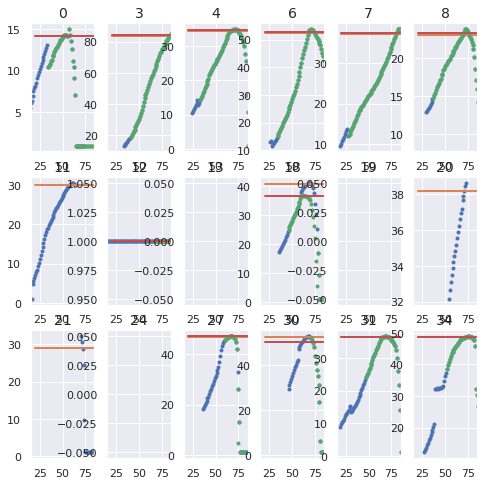

In [28]:
pad_ind_list = [13,11,19,24,30,21,18,27,8,0,31,12,6,34,3,20,4,7]
pad_ind_list = np.sort(np.array(pad_ind_list))
print(len(pad_ind_list))
fig, axs = plt.subplots(3,6,figsize=(8,8))
df_list = []
for prefix, diff in [('diff_', True), ('',False)]:
    for i, pad_ind in enumerate(pad_ind_list):
        ax = axs[np.int(i//6),np.mod(i, 6)]
        fn_tmpl = os.path.join(out_dir, "{}pad{}.csv".format(prefix,pad_ind))
        pad_df = pd.read_csv(fn_tmpl)
        pad_df['diff'] = diff
#         df_list.append(pad_df)
        sub_df = pad_df.loc[(pad_df.rad>0)&(pad_df.channel==5),:].groupby('frame').agg(np.max).reset_index()
        max_col = sub_df.rad.quantile(0.9)
        ax.plot((sub_df.frame), sub_df.rad,'.')
        ax.plot([20,90], [max_col, max_col],'-')
        ax.set_title(pad_ind)
        ax.set_xlim([15,85])
# cross_df = pd.concat(df_list)    

In [9]:
cross_df.shape

(53311812, 12)

In [78]:
def est_lam(pad_ind, diff=False):
    out_dir = os.path.join(acq.super_dir, 'csvs')
    prefix = ''
    if diff:
        prefix = 'diff_'
    fn_tmpl = os.path.join(out_dir, "{}pad{}.csv".format(prefix,pad_ind))
    pad_df = pd.read_csv(fn_tmpl)
    pad_ss = pad_df.loc[pad_df.channel==2,['fluor','frame']].groupby('frame').agg(np.sum)
    pad_ss = pad_ss.loc[slice(18,70),:].reset_index()
    pad_ss = pad_ss.sort_values(by='frame')
    fv = pad_ss.frame.values.astype(np.int)
    time_vec = np.array([acq.time_df.loc[(xx, pad_ind),'time'] for xx in fv])
    if len(pad_ss) > 12:
        med_vec = signal.savgol_filter(pad_ss.fluor.values, 9, 1)
    else:
        med_vec = pad_ss.fluor.values
    med_vec[med_vec<1] = 1
    y_vec = np.diff(np.log(med_vec))/np.diff(time_vec)
    bool_vec = (y_vec<1e-3)&(y_vec>1e-4)
    return np.median(y_vec[bool_vec]), pad_ss.frame.values[:-1][bool_vec]
#     return y_vec[bool_vec], time_vec[:-1][bool_vec]

/home/jparkin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jparkin/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


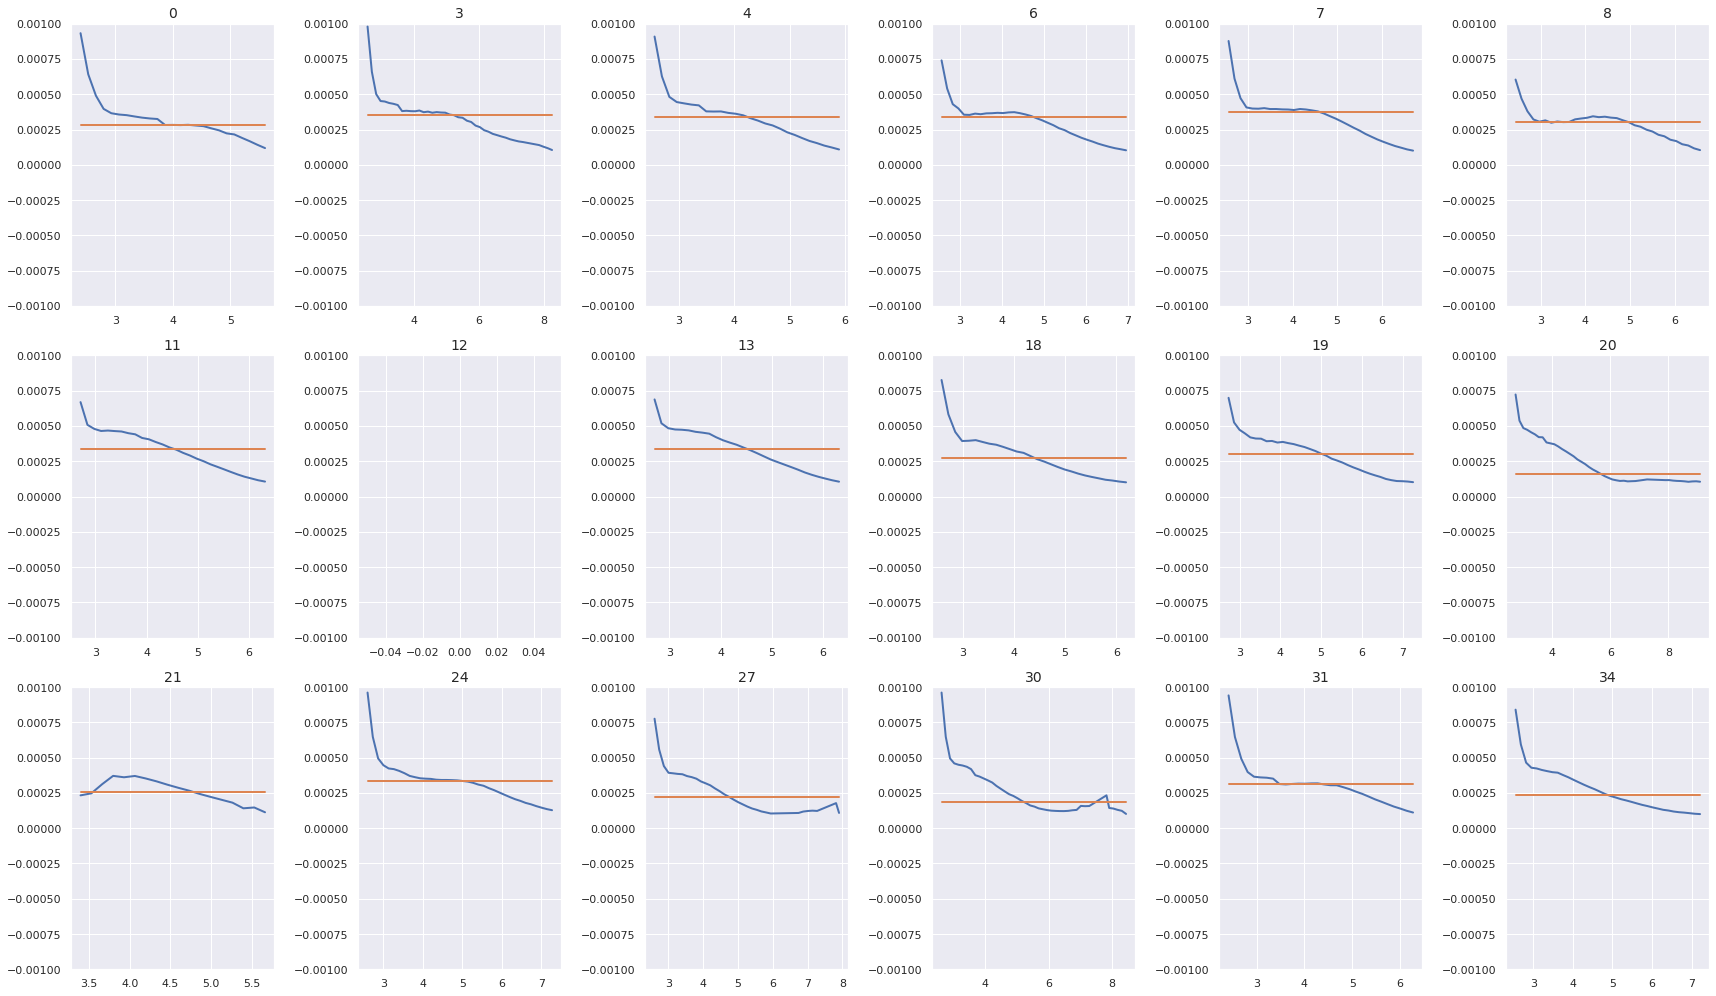

In [77]:
fig, axs = plt.subplots(3,6,figsize=(24,14))
for i, pad_ind in enumerate(pad_ind_list):
    ax = axs[np.int(i//6),np.mod(i, 6)]
    y_vec, time_vec = est_lam(pad_ind)
#     if len(time_vec) > 1:
#         x_vec = time_vec[:-1]
#     else:
    x_vec = time_vec
    ax.plot(x_vec/3600, y_vec)
    ax.plot(x_vec/3600, np.ones_like(x_vec)*np.median(y_vec))
    ax.set_title(np.int(pad_ind))
    ax.set_ylim([-0.001,0.001])
fig.tight_layout()

In [30]:
import itertools
all_dfs = []
loop_var = itertools.product([True, False], np.arange(36))
for diff, pad_ind in loop_var: 
    prefix = ['diff_',''][np.int(diff)]
    peak_out_fn = os.path.join(acq.super_dir, "csvs", '{}peaks_pad{}.csv').format(prefix, pad_ind)
    pad_fn = os.path.join(acq.super_dir, "csvs", '{}pad{}.csv').format(prefix, pad_ind)
    if os.path.exists(peak_out_fn):
        in_df = pd.read_csv(peak_out_fn)
        in_df['rad']=0
        pad_df = pd.read_csv(pad_fn)
        rad_df = pad_df[['frame','channel','rad']].groupby(['frame','channel']).agg(np.min)
        in_gb = in_df.groupby(['frame','channel'])
        for key, sub_df in in_gb:
            if key in rad_df.index:
                in_df.loc[sub_df.index,'rad'] = rad_df.loc[key,'rad']
        all_dfs.append(in_df)
peaks_df = pd.concat(all_dfs, ignore_index=True)

In [31]:
gb_lcp = peaks_df.groupby(['level','channel','pad'])
min_rows = []
for key, sub_df in gb_lcp:
    sub_df = sub_df.sort_values(by='dist_binned').reset_index()
    min_rows.append(sub_df.iloc[[0],:])
mins_df = pd.concat(min_rows,ignore_index=True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


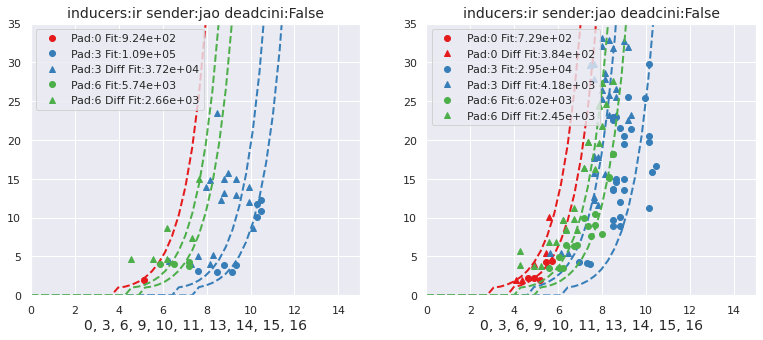

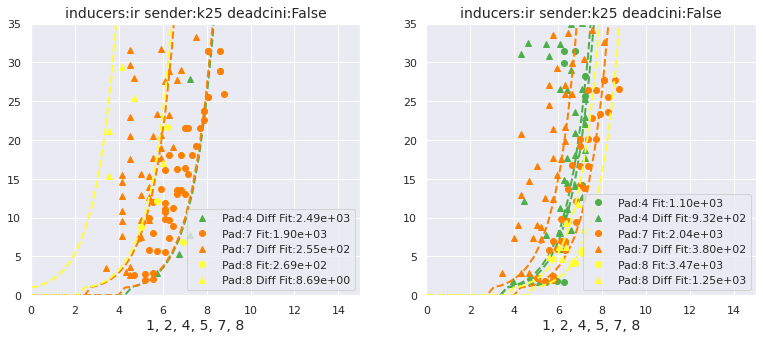

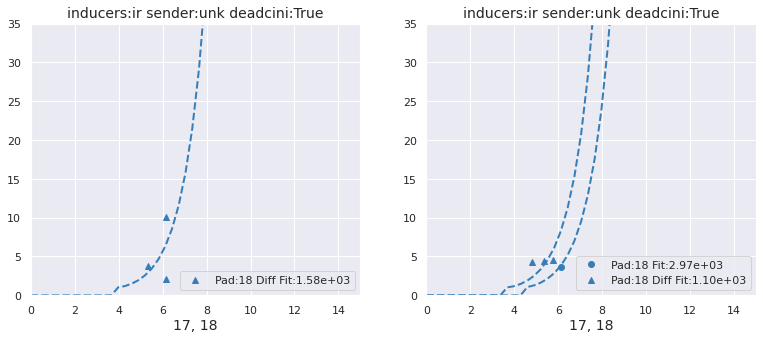

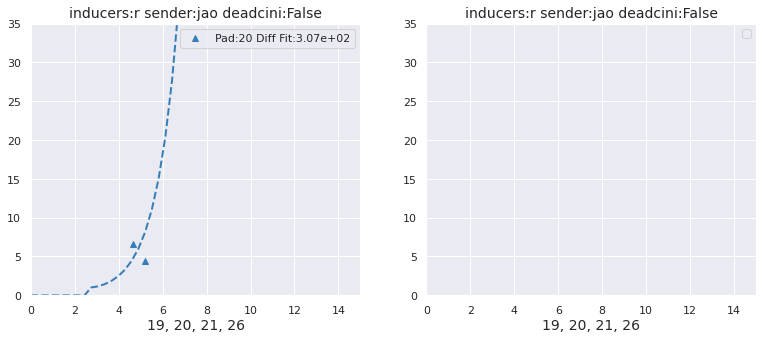

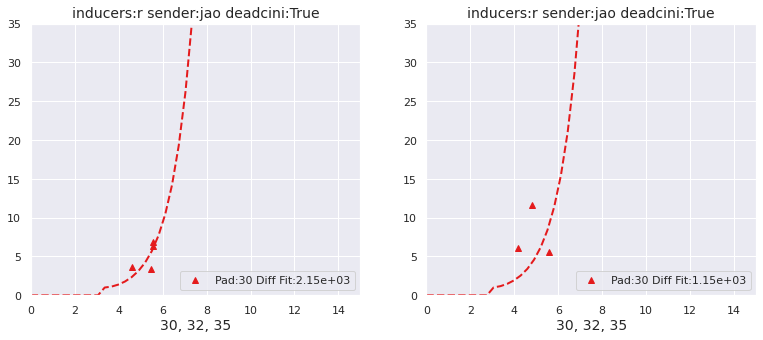

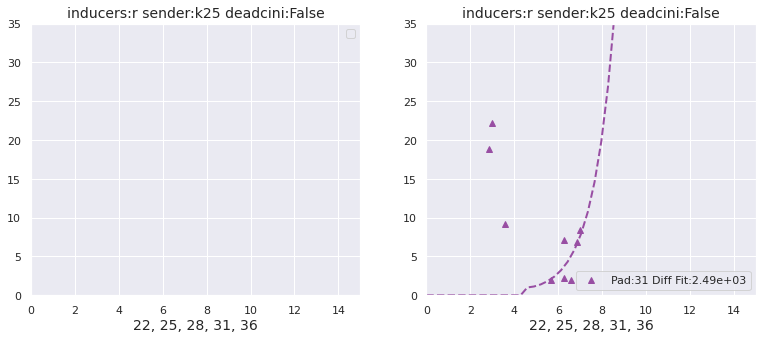

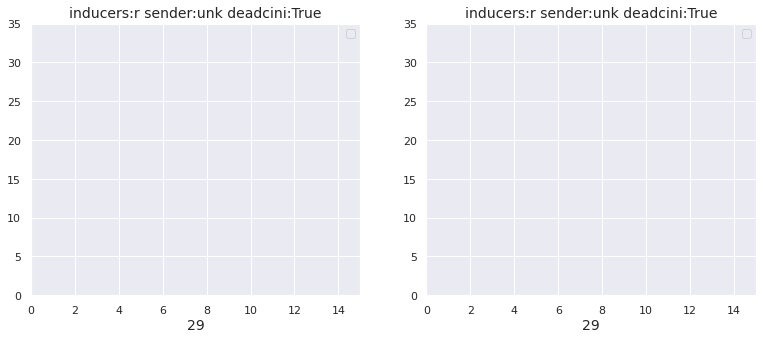

In [101]:
# gb_pad = mins_df.loc[mins_df.level<8,:].groupby('pad')
# gb_pad = mins_df.groupby('pad')
# gb_pad = peaks_df.groupby('pad')

def fn(p, t, radval):
    argument = p*np.exp(-t)/radval
    yvec=1/np.sin(argument)
    yvec[argument<0] = 0
    yvec[argument>np.pi/2] = 0
    return yvec

def res(p, t, y, radval):
    yvec = fn(p, t, radval)
    return np.sum(np.log(np.power(y-yvec,2)/100+1))

gb_pad = peaks_df.loc[(peaks_df.level<3)&(peaks_df.frame<85)&(peaks_df.channel>2)&(peaks_df['diff']>=0),:].groupby('pad')
metadata_df.loc[metadata_df.sender.isna(),'sender'] = 'unk'
metadata_gb = metadata_df.loc[metadata_df.skip==False,:].groupby(['inducers','sender','deadcini'])
for key, sub_df in metadata_gb:
    fig, axs = plt.subplots(1,2,figsize=(13,5))
    pad_list = np.unique(sub_df.index.values)
    n_pads = len(pad_list)
    if n_pads >= 1:
        c_vec = list(plt.cm.Set1.colors)
        c_dict = dict(zip(pad_list, c_vec))
    for ind in sub_df.index.values:
        if ind in gb_pad.groups.keys():
            sub_pad_df = gb_pad.get_group(ind)
            sub_gb_cd = sub_pad_df.groupby(['channel','diff'])
            for sub_key, plot_df in sub_gb_cd:
                chan, diff = sub_key
                lam, frame_vec = est_lam(ind)
                bool_vec = np.array([xx in frame_vec for xx in plot_df.frame.values])
                plot_df = plot_df.loc[bool_vec,:]
                ax_i = np.int(chan//4)
                radval = plot_df.rad.quantile(0.5)
                y = (plot_df.dist_binned + plot_df.rad)/radval
                m = ['o','^'][np.int(diff)]
                tvec = plot_df.time*lam
                res_lam = lambda p : res(p, tvec, y, radval)
                afit = opt.minimize(res_lam, 10)
                tsim = np.linspace(0,15,50)
                ysim = fn(afit.x, tsim, radval)
                dstr = ['',' Diff'][np.int(diff)]
                label = "Pad:{}{} Fit:{:02.2e}".format(ind, dstr, afit.x[0])
                if len(y)>0:
                    axs[ax_i].plot(tvec, y, m, label=label, c=c_dict[ind])
                    axs[ax_i].plot(tsim, ysim, '--', c=c_dict[ind])
    for ax in axs:
        title_tmpl = 'inducers:{} sender:{} deadcini:{}'
        title_vals = [str(xx) for xx in sub_df[['inducers','sender','deadcini']].values[0,:]]
        ax.set_title(title_tmpl.format(*title_vals))
        ax.set_xlabel(', '.join([str(xx) for xx in sub_df.index.values]))
        ax.set_xlim([0,15])
        ax.set_ylim([0,35])
#         for factor in [0.1, 1, 10]:
#             tvec = np.linspace(0,12,50)
#             argument = factor*100*np.exp(-tvec)
#             yvec=1/np.sin(argument)
#             yvec[argument<0] = 0
#             yvec[argument>np.pi/2] = 0
#             ax.plot(tvec,yvec)
        ax.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


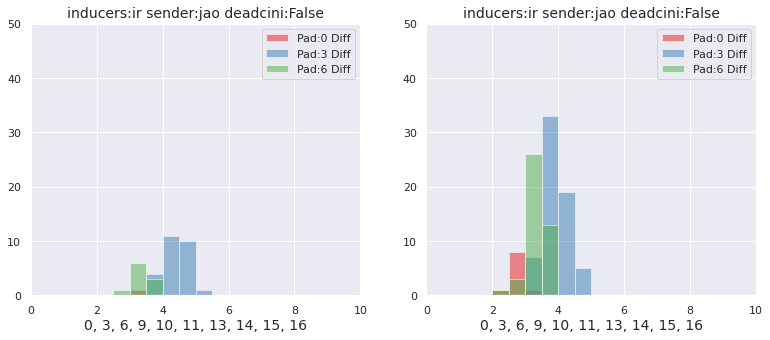

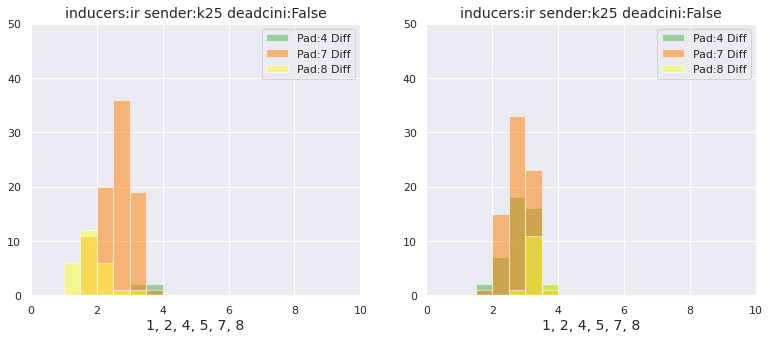

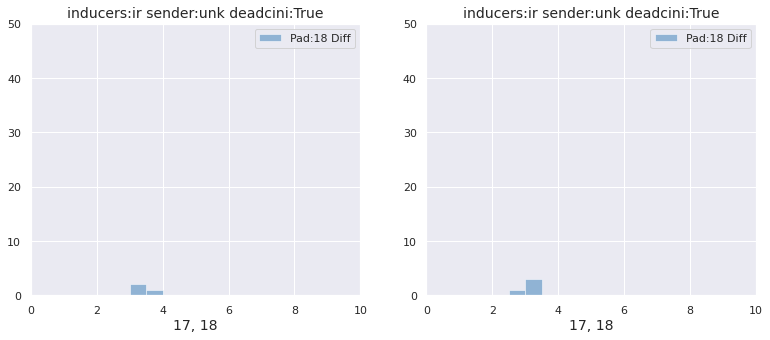

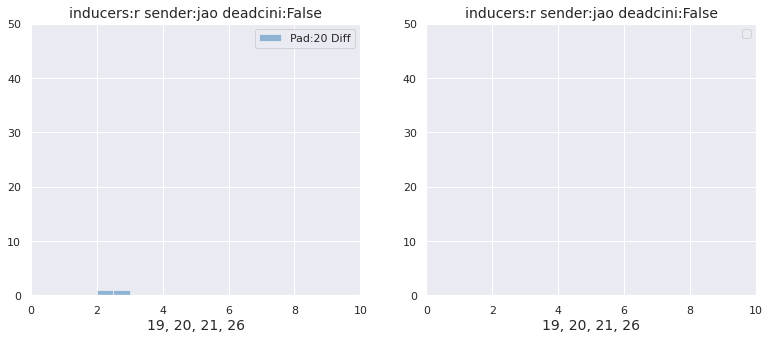

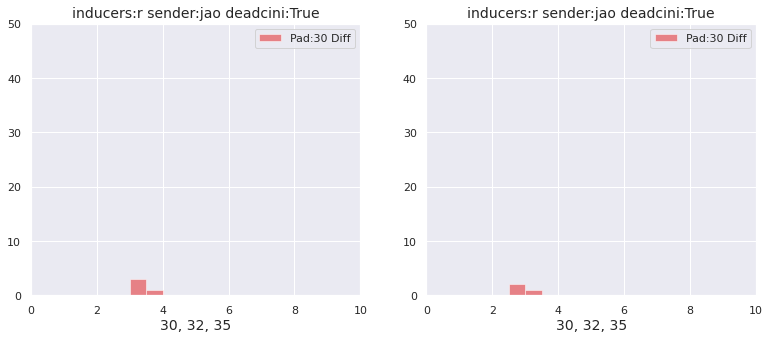

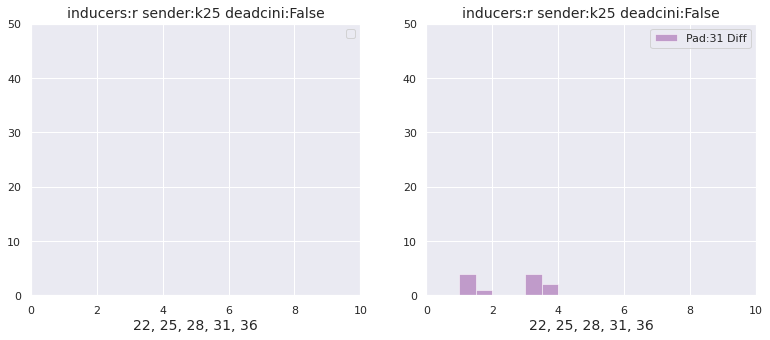

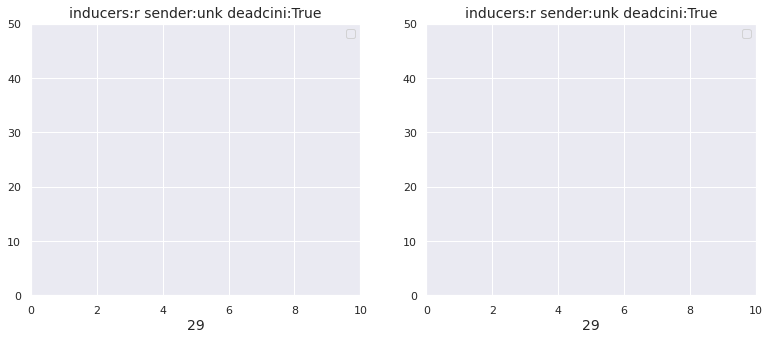

In [100]:
# gb_pad = mins_df.loc[mins_df.level<8,:].groupby('pad')
# gb_pad = mins_df.groupby('pad')
# gb_pad = peaks_df.groupby('pad')
# gb_pad = peaks_df.loc[(peaks_df.level<3)&(peaks_df.frame<65)&(peaks_df.channel>2),:].groupby('pad')
# metadata_df.loc[metadata_df.sender.isna(),'sender'] = 'unk'
# metadata_gb = metadata_df.loc[metadata_df.skip==False,:].groupby(['inducers','sender','deadcini'])
for key, sub_df in metadata_gb:
    fig, axs = plt.subplots(1,2,figsize=(13,5))
    pad_list = np.unique(sub_df.index.values)
    n_pads = len(pad_list)
    if n_pads >= 1:
        c_vec = list(plt.cm.Set1.colors)
        c_dict = dict(zip(pad_list, c_vec))
    for ind in sub_df.index.values:
        if ind in gb_pad.groups.keys():
            sub_pad_df = gb_pad.get_group(ind)
            sub_gb_cd = sub_pad_df.groupby(['channel'])
            for key, plot_df in sub_gb_cd:
#                 chan, diff = key
                chan = key
#                 ax_i = np.int(key[0]//4)
                ax_i = np.int(key//4)
                lam, frame_vec = est_lam(ind)
                bool_vec = np.array([xx in frame_vec for xx in plot_df.frame.values])
                plot_df = plot_df.loc[bool_vec,:]
                radval = plot_df.rad.quantile(0.5)
                rri = (plot_df.dist_binned + plot_df.rad)/radval
                y = np.arcsin(1/rri)*np.exp(plot_df.time*lam)*radval
                y = np.log10(y)
                if len(y)>0:
                    label = "Pad:{}{}".format(ind, ['',' Diff'][np.int(diff)])
                    _ = axs[ax_i].hist(y, label=label, color=c_dict[ind],alpha=0.5,bins=np.arange(0,10,0.5))
    for ax in axs:
        title_tmpl = 'inducers:{} sender:{} deadcini:{}'
        title_vals = [str(xx) for xx in sub_df[['inducers','sender','deadcini']].values[0,:]]
        ax.set_title(title_tmpl.format(*title_vals))
        ax.set_xlabel(', '.join([str(xx) for xx in sub_df.index.values]))
        ax.set_xlim([0,10])
        ax.set_ylim([0,50])
        ax.legend()

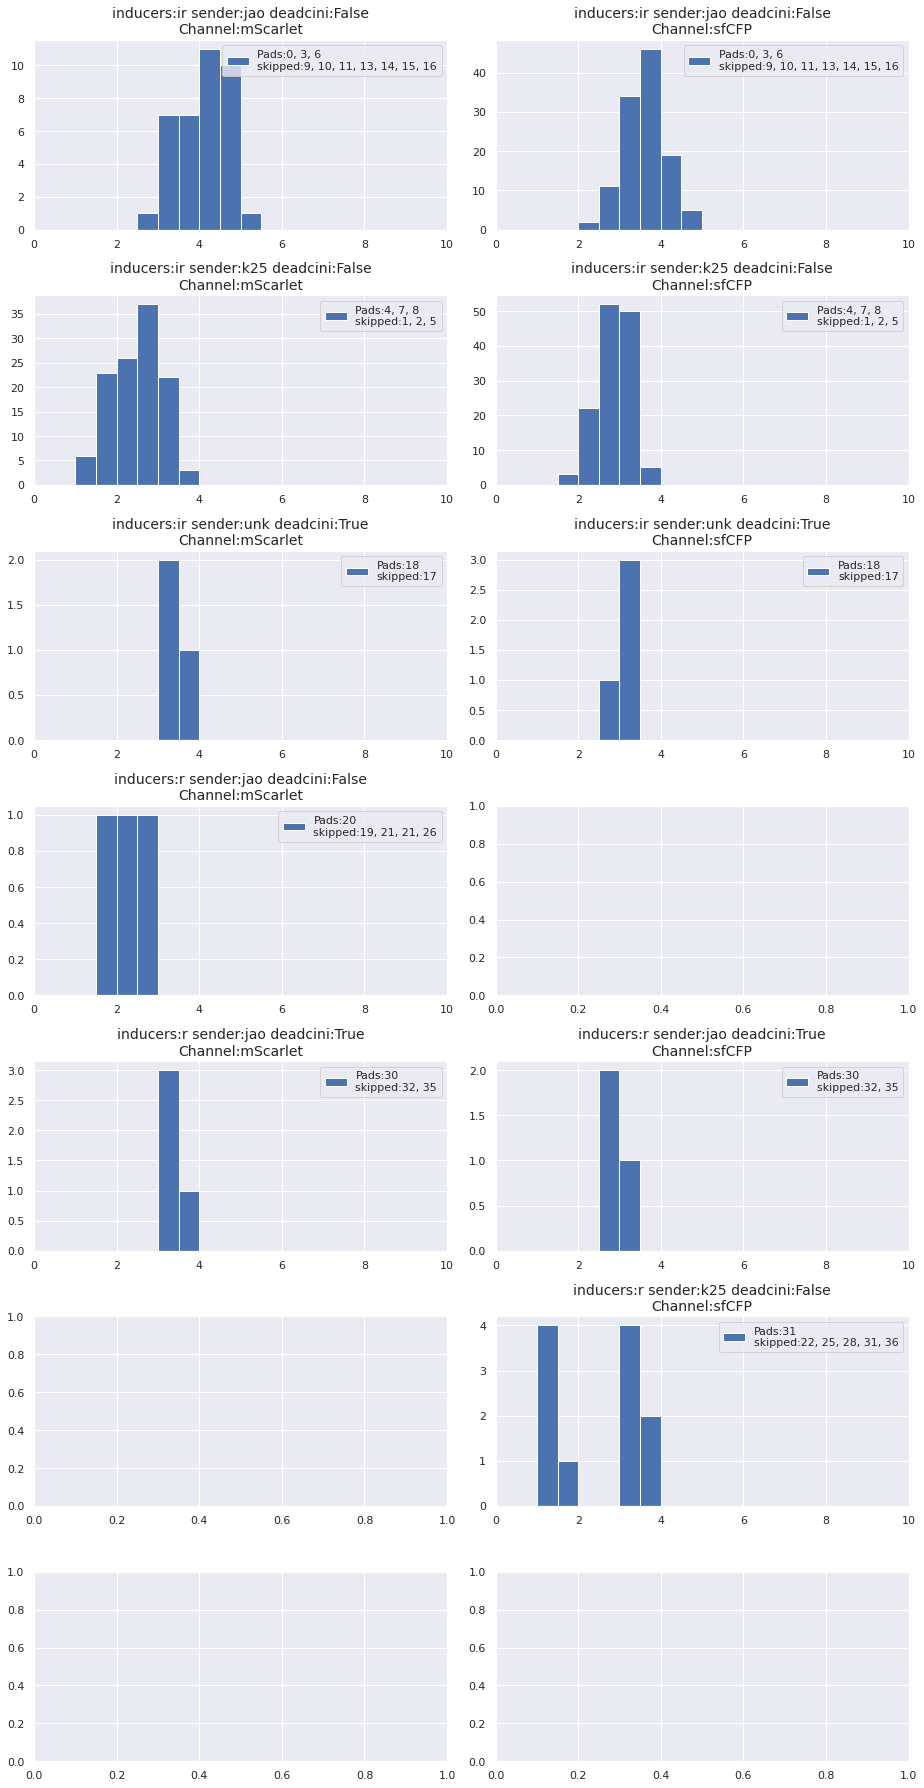

In [102]:
# gb_pad = mins_df.loc[mins_df.level<8,:].groupby('pad')
# gb_pad = mins_df.groupby('pad')
# gb_pad = peaks_df.groupby('pad')
peaks_df['y'] = np.nan
peaks_df['mdi'] = np.nan
# gb_pad = peaks_df.loc[(peaks_df.level<3)&(peaks_df.frame<65)&(peaks_df.channel>2),:].groupby('pad')
# metadata_df.loc[metadata_df.sender.isna(),'sender'] = 'unk'
# metadata_gb = metadata_df.loc[metadata_df.skip==False,:].groupby(['inducers','sender','deadcini'])
md_list = metadata_gb.agg(np.min).index.values
ax_nw = len(metadata_gb)
fig, axs = plt.subplots(ax_nw, 2,figsize=(13,25))
skipped_pads_list = []
for md_i, loopvar in enumerate(metadata_gb):
    key, sub_df = loopvar
    skipped_pads = []
    for ind in sub_df.index.values:
        if ind in gb_pad.groups.keys():
            sub_pad_df = gb_pad.get_group(ind)
            sub_gb_cd = sub_pad_df.groupby(['channel'])
            for key, plot_df in sub_gb_cd:
                lam, frame_vec = est_lam(ind)
                bool_vec = np.array([xx in frame_vec for xx in plot_df.frame.values])
                plot_df = plot_df.loc[bool_vec,:]
                if np.any(bool_vec):
                    radval = plot_df.rad.quantile(0.5)
                    rri = (plot_df.dist_binned + plot_df.rad)/radval
                    y = np.arcsin(1/rri)*np.exp(plot_df.time*lam)*radval
                    y = np.log10(y)
                    peaks_df.loc[plot_df.index, 'y'] = y
                    peaks_df.loc[plot_df.index, 'mdi'] = md_i
                else:
                    skipped_pads.append(ind)
        else:
            skipped_pads.append(ind)
    skipped_pads_list.append(skipped_pads)

peaks_gb_md = peaks_df.groupby(['mdi','channel'])
for key, sub_df in peaks_gb_md:
    md_i, chan_i = [int(xx) for xx in key]
    skipped_pads = skipped_pads_list[md_i]
    md_vals = md_list[int(md_i)]
    y = sub_df['y']
    lab_val = ', '.join([str(xx) for xx in np.unique(sub_df['pad'].values)])
    skpd_str = ', '.join([str(xx) for xx in skipped_pads])
    label = "Pads:{}\nskipped:{}".format(lab_val, skpd_str)
    ax_i = np.int(chan_i//4)
    ax = axs[np.int(md_i), np.int(ax_i)]
    _ = ax.hist(y, label=label,bins=np.arange(0,10,0.5))
    title_tmpl = 'inducers:{} sender:{} deadcini:{}\nChannel:{}'
    title_vals = [str(xx) for xx in metadata_gb.agg(np.min).index.values[md_i]]
    title_vals.append(mma.all_channel_names[chan_i])
    ax.set_title(title_tmpl.format(*title_vals))
#     ax.set_xlabel(label)
    ax.set_xlim([0,10])
#     ax.set_ylim([0,50])
    ax.legend()
fig.tight_layout()

In [ ]:
# gb_pad = mins_df.loc[mins_df.level<8,:].groupby('pad')
# gb_pad = mins_df.groupby('pad')
# gb_pad = peaks_df.groupby('pad')
peaks_df['y'] = np.nan
peaks_df['mdi'] = np.nan
# gb_pad = peaks_df.loc[(peaks_df.level<3)&(peaks_df.frame<65)&(peaks_df.channel>2),:].groupby('pad')
# metadata_df.loc[metadata_df.sender.isna(),'sender'] = 'unk'
# metadata_gb = metadata_df.loc[metadata_df.skip==False,:].groupby(['inducers','sender','deadcini'])
md_list = metadata_gb.agg(np.min).index.values
ax_nw = len(metadata_gb)
fig, axs = plt.subplots(ax_nw, 2,figsize=(13,25))
skipped_pads_list = []
for md_i, loopvar in enumerate(metadata_gb):
    key, sub_df = loopvar
    skipped_pads = []
    for ind in sub_df.index.values:
        if ind in gb_pad.groups.keys():
            sub_pad_df = gb_pad.get_group(ind)
            sub_gb_cd = sub_pad_df.groupby(['channel'])
            for key, plot_df in sub_gb_cd:
                lam, frame_vec = est_lam(ind)
                bool_vec = np.array([xx in frame_vec for xx in plot_df.frame.values])
                plot_df = plot_df.loc[bool_vec,:]
                if np.any(bool_vec):
                    radval = plot_df.rad.quantile(0.5)
                    rri = (plot_df.dist_binned + plot_df.rad)/radval
                    y = np.arcsin(1/rri)*np.exp(plot_df.time*lam)*radval
                    y = np.log10(y)
                    peaks_df.loc[plot_df.index, 'y'] = y
                    peaks_df.loc[plot_df.index, 'mdi'] = md_i
                else:
                    skipped_pads.append(ind)
        else:
            skipped_pads.append(ind)
    skipped_pads_list.append(skipped_pads)

peaks_gb_md = peaks_df.groupby(['mdi','channel'])
keys = list(peaks_gb_md.groups.keys())
key_ind_dict = dict(zip(keys, np.arange(len(keys))))
for key, sub_df in peaks_gb_md:
    key_ind = key_ind_dict[key]
    md_i, chan_i = [int(xx) for xx in key]
    skipped_pads = skipped_pads_list[md_i]
    md_vals = md_list[int(md_i)]
    y = sub_df['y']
    lab_val = ', '.join([str(xx) for xx in np.unique(sub_df['pad'].values)])
    skpd_str = ', '.join([str(xx) for xx in skipped_pads])
    label = "Pads:{}\nskipped:{}".format(lab_val, skpd_str)
    ax_i = np.int(chan_i//4)
    ax = axs[np.int(md_i), np.int(ax_i)]
    _ = ax.hist(y, label=label,bins=np.arange(0,10,0.5))
    title_tmpl = 'inducers:{} sender:{} deadcini:{}\nChannel:{}'
    title_vals = [str(xx) for xx in metadata_gb.agg(np.min).index.values[md_i]]
    title_vals.append(mma.all_channel_names[chan_i])
    ax.set_title(title_tmpl.format(*title_vals))
#     ax.set_xlabel(label)
    ax.set_xlim([0,10])
#     ax.set_ylim([0,50])
    ax.legend()
fig.tight_layout()

In [124]:
peaks_df.loc[np.isfinite(peaks_df.y),:]

dist_binned  frame  level       thresh  channel                acqname  \
0       11.309375   38.0      0   211.959430      3.0  200626_finalday_img_1   
53      14.540625   34.0      0  2103.301000      5.0  200626_finalday_img_1   
59      14.540625   36.0      1  4603.301000      5.0  200626_finalday_img_1   
60      37.159375   40.0      1  4603.301000      5.0  200626_finalday_img_1   
64      11.309375   38.0      2  7103.301000      5.0  200626_finalday_img_1   
...           ...    ...    ...          ...      ...                    ...   
3243   667.253125   28.0      0    24.558213      5.0  200626_finalday_img_1   
3245    17.771875   42.0      1   274.558213      5.0  200626_finalday_img_1   
3246    95.321875   46.0      1   274.558213      5.0  200626_finalday_img_1   
3247   121.171875   47.0      1   274.558213      5.0  200626_finalday_img_1   
3266    11.309375   44.0      2   524.558213      5.0  200626_finalday_img_1   

              time  pad   diff        rad         y  mdi  
0     18239.666667    0  False  11.311651  3.014685  0.0  
53    16319.666667    0  False  10.432809  2.773874  0.0  
59    17279.666667    0  False  10.785236  2.885256  0.0  
60    19199.666667    0  False  11.849744  2.821587  0.0  
64    18239.666667    0  False  11.311651  3.057249  0.0  
...            ...  ...    ...        ...       ...  ...  
3243  13471.666667   31   True  14.003017  1.453306  5.0  
3245  20192.333333   31   True  20.177329  3.628693  5.0  
3246  22112.333333   31   True  23.221377  3.377963  5.0  
3247  22592.333333   31   True  24.030236  3.353997  5.0  
3266  21152.000000   31   True  21.743115  3.823724  5.0  

[431 rows x 12 columns]

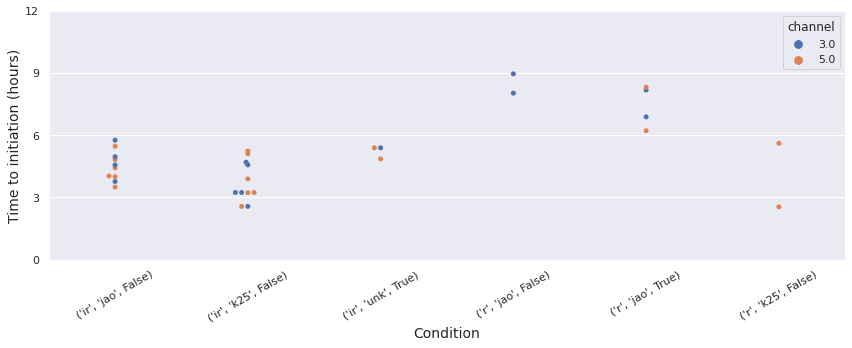

In [133]:
agg_peaks = peaks_df.loc[np.isfinite(peaks_df.y),:].groupby(['pad','channel','level','diff']).agg(np.min).reset_index()
plt.figure(figsize=(12,5))
plot_df = agg_peaks.loc[agg_peaks.channel>2,:]
plot_df = plot_df.loc[plot_df['diff']==True,:]
plot_df = plot_df.loc[plot_df['level']<2,:]
sns.swarmplot(data=plot_df, x='mdi',y='time',hue='channel')
mdlabels = list(metadata_gb.groups.keys())
_ = plt.xticks(np.arange(6), mdlabels[:-1],rotation=30)
_ = plt.xlabel('Condition')
_ = plt.ylabel('Time to initiation (hours)')
tpoints = np.linspace(0,12,5)
_ = plt.yticks(tpoints*3600,tpoints.astype(np.int))
plt.tight_layout()

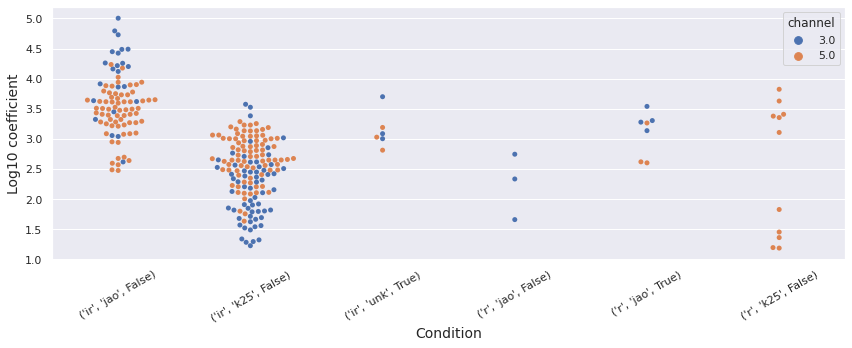

In [129]:
plt.figure(figsize=(12,5))
plot_df = peaks_df.loc[peaks_df.channel>2,:]
plot_df = plot_df.loc[plot_df['diff']==True,:]
sns.swarmplot(data=plot_df, x='mdi',y='y',hue='channel')
mdlabels = list(metadata_gb.groups.keys())
_ = plt.xticks(np.arange(6), mdlabels[:-1],rotation=30)
_ = plt.xlabel('Condition')
_ = plt.ylabel('Log10 coefficient')
plt.tight_layout()

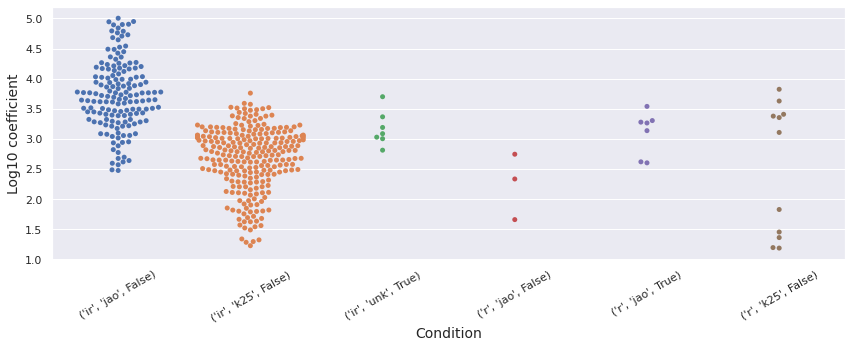

In [113]:
plt.figure(figsize=(12,5))
sns.swarmplot(data=peaks_df, x='mdi',y='y')
mdlabels = list(metadata_gb.groups.keys())
_ = plt.xticks(np.arange(6), mdlabels[:-1],rotation=30)
_ = plt.xlabel('Condition')
_ = plt.ylabel('Log10 coefficient')
plt.tight_layout()

In [97]:
key = ('r','jao',False)
sub_df = metadata_gb.get_group(key)
pad_list = np.unique(sub_df.index.values)
n_pads = len(pad_list)
# for ind in sub_df.index.values:
ind = 21
if ind in gb_pad.groups.keys():
    sub_pad_df = gb_pad.get_group(ind)
    sub_gb_cd = sub_pad_df.groupby(['channel'])
    key2 = 3.0
    plot_df = sub_gb_cd.get_group(key2)
    chan = key
#     ax_i = np.int(key//4)
    lam, frame_vec = est_lam(ind)
#     bool_vec = np.array([xx in frame_vec for xx in plot_df.frame.values])
#     plot_df = plot_df.loc[bool_vec,:]
    radval = plot_df.rad.quantile(0.5)
    rri = (plot_df.dist_binned + plot_df.rad)/radval
    y = np.arcsin(1/rri)*np.exp(plot_df.time*lam)*radval
    y = np.log10(y)
    label = "Pad:{}{}".format(ind, ['',' Diff'][np.int(diff)])


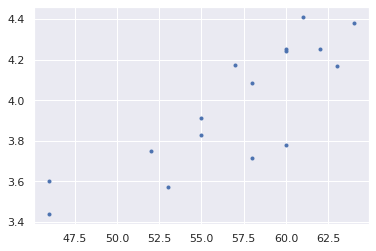

In [99]:
plt.plot(plot_df.frame, y,'.')

In [244]:
mma = importlib.reload(mma)

In [245]:
# investigation peaks in pad 21 that don't appear in the GIF
proc = mma.ProcessUnorderedDiff(acq, 7, 1, 2, 64, print_img=False
                                , diff=True, bg_option='pos_list')
# proc.diff
# proc.begin()

In [246]:
proc.process_frame_stacks(32)

frame    x    y  pad        fluor  channel  scale      thresh  \
0      32.0  262  362  7.0   121.406067      2.0    1.0   49.881943   
1      32.0  263  362  7.0   112.766716      2.0    1.0   49.881943   
2      32.0  264  362  7.0    98.043907      2.0    1.0   49.881943   
3      32.0  265  362  7.0    81.196495      2.0    1.0   49.881943   
4      32.0  266  362  7.0    65.331078      2.0    1.0   49.881943   
...     ...  ...  ...  ...          ...      ...    ...         ...   
2412   32.0  266  434  7.0  1332.901855      5.0    1.0  441.600525   
2413   32.0  262  435  7.0  1223.542969      5.0    1.0  441.600525   
2414   32.0  263  435  7.0  1299.582886      5.0    1.0  441.600525   
2415   32.0  264  435  7.0  1331.372925      5.0    1.0  441.600525   
2416   32.0  265  435  7.0  1318.852539      5.0    1.0  441.600525   

           dist        rad  
0      0.000000  17.366766  
1      0.000000  17.366766  
2      0.000000  17.366766  
3      0.000000  17.366766  
4      1.615625  17.366766  
...         ...        ...  
2412  85.628125  17.366766  
2413  87.243750  17.366766  
2414  87.243750  17.366766  
2415  87.243750  17.366766  
2416  87.243750  17.366766  

[2417 rows x 10 columns]

In [227]:
proc.begin_stacks()

In [224]:
np.min?

In [264]:
im_dist, thresh, rad_arr = proc._yfp_dist(35)

In [257]:
d_coeff*np.sqrt(np.sum(lab_arr>0)/np.pi)

14.669506721985943

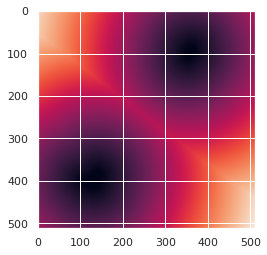

In [268]:
thresh_arr, chan_arr, thresh = proc._chan_thresh(35, 0, 'arr')
d_coeff = acq.pixel_size
lab_arr, n_senders = skimage.morphology.label(thresh_arr, return_num=True)
sen_labs = np.arange(n_senders)+1
rad_vec = [d_coeff*np.sqrt(np.sum(lab_arr==xx)/np.pi) for xx in sen_labs]
dist_arrs = [d_coeff*ndi.morphology.distance_transform_bf(lab_arr!=xx) for xx in sen_labs]
im_dist = d_coeff*ndi.morphology.distance_transform_bf(thresh_arr==False)
mask_arrs = [(im_dist==dist_arr) for dist_arr in dist_arrs]
plt.imshow(im_dist)

In [199]:
out_tmpl = os.path.join(acq.super_dir, 'csvs', 'diff_pad{}.csv')
pad_df = pd.read_csv(out_tmpl.format(proc.pad_ind))

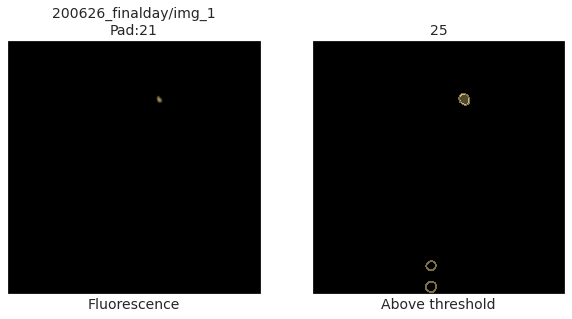

In [287]:
proc.printer.out_fn=''
proc.printer._setup_figure()
_ = proc.process_frame(25)

In [207]:
fitter = mma.FrontFitter(acq, True)
peak_df = fitter.pad_peaks(21)

In [288]:
gb_pad = peaks_df.loc[(peaks_df.level<3)&(peaks_df.frame<85)&(peaks_df.channel>2)&(peaks_df['diff']>=0),:].groupby('pad')
pad_df = gb_pad.get_group(21)

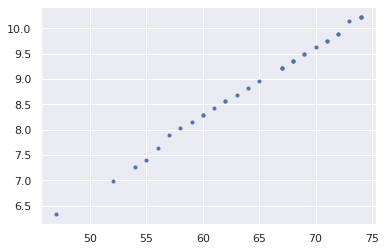

In [294]:
pad_df = pad_df.sort_values(by='frame')
plt.plot(pad_df.frame, pad_df.time/3600,'.')

In [195]:
diff_arr = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200626_finalday/img_1/diff_pad3.tif', memmap=True)
filt_arr = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200626_finalday/img_1/filt_pad3.tif', memmap=True)
diff_mask_arr = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200626_finalday/img_1/diff_pad3_masks.tif', memmap=True)
filt_mask_arr = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200626_finalday/img_1/filt_pad3_masks.tif', memmap=True)

In [62]:
pad_ind = 6
procdiff = mma.ProcessUnorderedDiff(acq, pad_ind, scale=1, sigma=2, bg_sigma=64, 
                                    print_img=True, bg_option='pos_list',diff=True)
plt.close('all')

In [63]:
f_i = 40
c_i = 2
im_dist, thresh, rad_arr = procdiff._yfp_dist(f_i)

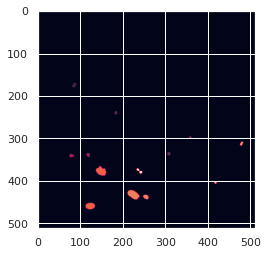

In [66]:
plt.imshow(chan_arr[30,:,:])

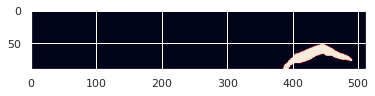

In [134]:
chan_arr, num = skimage.morphology.label(mask_arr[:,0,:,:]>0, return_num=True)
chan_arr>0
plt.imshow(chan_arr[:,:,150])

In [242]:
list(lab_gb.groups.keys())

[(0, False), (0, True), (1, False), (1, True), (2, False), (2, True)]

In [243]:
frame = 32
# lab_df = procdiff._make_lab_df_from_stacks()
yfp_mask = procdiff.filt_mask[frame,0,...].copy()
lab_gb = lab_df.groupby(['chan_i','diff'])
if (0, False) in lab_gb.groups:
    sub_lab_df = lab_gb.get_group((0, False))
    for lab in sub_lab_df.loc[sub_lab_df.duration<15,'label']:
        yfp_mask[yfp_mask==lab]=0
    thresh_arr = yfp_mask > 0
else:
    thresh_arr = None
thresh_arr

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [197]:
# make a dataframe that lists each label's start frame and duration in frames.
# include mask and diff as boolean columns as well, and a channel column
df_list = []
for diff, arr in zip([False, True], [filt_mask_arr, diff_mask_arr]):
    for chan_i in np.arange(3):
        chan_arr = arr[:,chan_i,...]
        num = np.int(chan_arr.max())
        nf, nh, nw = chan_arr.shape
        frames_vec = np.arange(nf)
        n_frames = []
        inds = np.arange(num).astype(np.int)
        cols = ['label','startframe','duration']
        n_c = len(cols)
        lab_df = pd.DataFrame(index=inds, columns=cols, data=np.zeros((num, n_c)).astype(np.int))
        for i in np.arange(num)+1:
            bool_vec = np.any(chan_arr==i,axis=(1,2))
            f_vec = frames_vec[bool_vec]
            n_frames.append(np.sum(bool_vec))
            lab_df.loc[i-1,:] = np.array([i, np.min(f_vec), np.sum(bool_vec)]).astype(np.int)
#         lab_df = pd.DataFrame(lab_df, dtype=np.int)
        lab_df['chan_i'] = chan_i
        lab_df['diff'] = diff
        df_list.append(lab_df)
lab_df = pd.concat(df_list, ignore_index=True)

In [207]:
thresh_arr = lab_arr > 0
frame_i = 14
# for frame_i in np.arange(nf):
im_mask = filt_mask_arr[frame_i,0,...].copy()
sub_lab_df = lab_df.groupby(['chan_i','diff']).get_group((0,False))
for lab in sub_lab_df.loc[sub_lab_df.duration<13,'label']:
    im_mask[im_mask==lab] = 0
im_thresh = im_mask > 0
im_dist = ndi.morphology.distance_transform_bf(im_thresh==0)

# for chan_i in np.arange(3):
#     im_yfp = filt_arr[frame_i,0,...]
#     im_mask = filt_mask_arr[frame_i,0,...].copy()
#     sub_lab_df = lab_df.groupby(['chan_i','diff']).get_group((2,True))
#     for lab in sub_lab_df.loc[sub_lab_df.duration<8,'label']:
#         im_mask[im_mask==lab] = 0
#     im_thresh = im_mask > 0

In [210]:
lab_df.groupby(['chan_i','diff']).get_group((2,True)).sort_values(by='duration')

label  startframe  duration  chan_i  diff
59     12          90         1       2  True
58     11          89         2       2  True
55      8          63         8       2  True
57     10          76        15       2  True
56      9          68        23       2  True
54      7          56        35       2  True
53      6          55        36       2  True
49      2          50        41       2  True
50      3          50        41       2  True
51      4          50        41       2  True
52      5          50        41       2  True
48      1          41        50       2  True

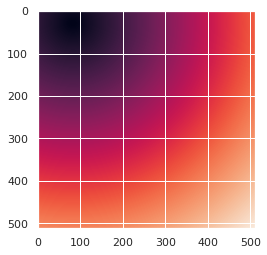

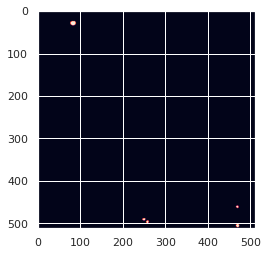

In [208]:
plt.imshow(im_dist)
plt.figure()
plt.imshow(filt_mask_arr[frame_i,0,...]>0)
# plt.imshow(filt_arr[frame_i,0,:,:])

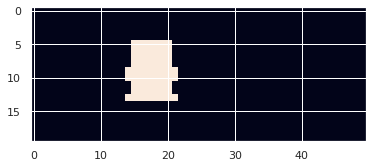

In [193]:
plt.imshow(filt_mask_arr[:20,0,95:105,150:200].sum(axis=1)>0)

In [196]:
np.any(filt_mask_arr[:,0,:,:]==2,axis=(1,2))

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])